# I. 개요

## 1. 데이터 소개

게임을 판매하는 웹 사이트인 Steam에서 제공하는 API를 통해 추출한 데이터 사용

## 2. 목표

- 게임에서 요구하는 컴퓨터의 최소 사양(RAM)이 게임 흥행에 미치는 영향 분석
- 게임에 대한 유저들의 평가 신뢰도 분석
- 배급사(Publisher)가 게임 흥행에 미치는 영향 분석

###### ※ RAM이 가장 직관적으로 수치화 할 수 있는 데이터이기 때문에 RAM을 기준으로 분석 진행

# II. 데이터 설정

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns
import numpy as np

from statsmodels.graphics.gofplots import qqplot
from scipy.stats import stats, shapiro, spearmanr, kruskal, chi2, levene, mannwhitneyu, ranksums
from scikit_posthocs import posthoc_dunn

import warnings
warnings.filterwarnings("ignore")

from edaplot.plot_functions import showplot
from edaplot.vis_module import vis_data, plot_histogram

In [2]:
# 폰트 경로 가져오기
font_path = "C:/Windows/Fonts/malgun.ttf"  # 맑은 고딕 폰트 파일 경로
font_name = font_manager.FontProperties(fname=font_path).get_name()

# 폰트 설정
rc('font', family=font_name)

In [3]:
df = pd.read_csv('merged.csv')

```python
from edaplot.plot_functions import showplot
from edaplot.vis_module import vis_data, plot_histogram
```
edaplot은 자체 제작 패키지

시각화용 함수 내장

<details>
<summary>소스 코드</summary>
<div markdown="1">
plot_functions.py

```python
import matplotlib.pyplot as plt
import seaborn as sns

def generate_colors(num_colors):
    colors = sns.color_palette("tab10", num_colors)
    return colors

def showplot(columnname, train):
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.facecolor'] = 'white'
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax = ax.flatten()
    value_counts = train[columnname].value_counts()
    labels = value_counts.index.tolist()

    # 색상 생성
    colors = generate_colors(len(value_counts))
    color_map = dict(zip(labels, colors))

    # Donut Chart
    wedges, texts, autotexts = ax[0].pie(
        value_counts, autopct='%1.1f%%', textprops={'size': 9, 'color': 'white', 'fontweight': 'bold'},
        colors=[color_map[x] for x in labels], wedgeprops=dict(width=0.35), startangle=80, pctdistance=0.85)

    # Circle
    centre_circle = plt.Circle((0, 0), 0.6, fc='white')
    ax[0].add_artist(centre_circle)

    # Count Plot
    colormap = {label: color for label, color in zip(labels, colors)}
    sns.countplot(data=train, y=columnname, ax=ax[1], order=labels, hue=columnname, palette=colormap, legend=False)
    for i, v in enumerate(value_counts):
        ax[1].text(v + 1, i, str(v), color='black', fontsize=10, va='center')
    sns.despine(left=True, bottom=True)
    plt.yticks(fontsize=9, color='black')
    ax[1].set_ylabel(None)
    plt.xlabel("")
    plt.xticks([])
    fig.suptitle(columnname, fontsize=15, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()
```


vismodle.py
```python
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

def vis_data(df, x, y, title=None, color_palette=None):
    grouped_data = df.groupby(x)[y].mean().reset_index()

    # 색상 팔레트 설정
    if color_palette is None:
        color_palette = sns.color_palette("tab10", len(grouped_data[x].unique()))
    colors = dict(zip(grouped_data[x].unique(), color_palette))

    # 바 차트 생성
    plt.figure(figsize=(8, 6))
    bars = plt.bar(grouped_data[x], grouped_data[y], color=[colors[x] for x in grouped_data[x]])

    # 범례 추가
    plt.legend(bars, grouped_data[x].unique())  # 바 객체와 고유한 x 값을 범례로 표시

    # 제목 설정 (선택사항)
    if title:
        plt.title(title)

    plt.xlabel(x)  # X축 레이블 설정
    plt.ylabel(y)  # Y축 레이블 설정
    plt.xticks(rotation=45)  # X 축 틱 라벨 45도 회전
    plt.tight_layout()  # 레이아웃 조정
    plt.show()

def plot_histogram(df, column, title=None, bins=10):
    plt.figure(figsize=(8, 6))
    plt.hist(df[column], bins=bins, edgecolor='black')

    if title:
        plt.title(title)

    plt.xlabel(column)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
```

## 1. 기반 데이터 생성

RAM 데이터의 경우 최소 사양을 기록한 데이터에서 RAM의 최소 요구 사양을 추출해 MB의 단위로 통일해 저장한 데이터프레임

<details>
<summary>RAM 데이터 추출 코드</summary>
<div markdown="1">

```python
import pandas as pd
import numpy as np

df = pd.read_csv('data/steam_requirements_data.csv')

def get_RAM(text_list):
    result = []
    for idx, text in enumerate(text_list):
        try:
            ram_value = None
            text = str(text)
            words = text.split()
            if text.startswith('A 100% Windows'):
                result.append(0)
                continue
    
            for i, item in enumerate(words):
                if 'ram' in item.lower() or 'ram,' in item.lower():
                    if words[i-1].lower() == 'gb' or words[i-1].lower() == 'gigabytes':
                        ram_value = words[i-2] + 'gb'
                    elif words[i-1].lower() == 'mb' or words[i-1].lower() == 'megabytes':
                        ram_value = words[i-2] + 'mb'
                    elif words[i-1].lower() == 'kb' or words[i-1].lower() == 'kilobyte':
                        ram_value = words[i-2] + 'kb'
                    else:
                        ram_value = words[i-1]
                    break
                elif 'memory:' in item.lower():
                    if words[i+2].lower() == 'gb' or words[i+2].lower() == 'gigabytes':
                        ram_value = words[i+1] + 'gb'
                    elif words[i+2].lower() == 'mb' or words[i+2].lower() == 'megabytes':
                        ram_value = words[i+1] + 'mb'
                    elif words[i-1].lower() == 'kb' or words[i+2].lower() == 'kilobyte':
                        ram_value = words[i+1] + 'kb'
                    else:
                        ram_value = words[i+1]
                    break
                elif 'system' in item.lower() and words[i+1].lower().startswith('memory'):
                    if words[i-1].lower() == 'gb' or words[i-1].lower() == 'gigabytes':
                        ram_value = words[i-2] + 'gb'
                    elif words[i-1].lower() == 'mb' or words[i-1].lower() == 'megabytes':
                        ram_value = words[i-2] + 'mb'
                    elif words[i-1].lower() == 'kb' or words[i-1].lower() == 'kilobyte':
                        ram_value = words[i-2] + 'kb'
                    else:
                        ram_value = words[i-1]
                    break
            result.append(ram_value)
        except IndexError:
            result.append(ram_value)
            print(f"Error Index : {idx}")
    return result

def convert_to_mb(lst):
    converted_lst = []
    for item in lst:
        if isinstance(item, int) or isinstance(item, float):
            converted_lst.append(item)
        elif isinstance(item, str):
            item = item.lower().strip()
            if item.isdigit():
                converted_lst.append(int(item))
            elif 'mb' in item:
                value = item.replace('mb', '')
                if value.isdigit():
                    converted_lst.append(int(value))
                else:
                    converted_lst.append(None)
            elif 'kb' in item:
                value = item.replace('kb', '')
                if value.isdigit():
                    converted_lst.append(int(float(value) / 1024))
                else:
                    converted_lst.append(None)
            elif 'gb' in item:
                value = item.replace('gb', '')
                if value.isdigit():
                    converted_lst.append(int(float(value) * 1024))
                else:
                    converted_lst.append(None)
            else:
                converted_lst.append(None)
        else:
            converted_lst.append(None)
    return converted_lst

result = get_RAM(df['minimum'])

mb_rs = convert_to_mb(result)

result_Data = pd.DataFrame()
result_Data['appid'] = df['steam_appid']
result_Data['Min RAM(MB)'] = mb_rs

result_Data.to_csv('data/RAM_info.csv', index=False)
```

RAM 데이터와 기존 데이터를 INNER JOIN 해 데이터를 병합하고 요구 사양을 추출하지 못한 데이터를 Drop 처리

<details>
<summary>데이터 병합 코드</summary>
<div markdown="1">

```python
import pandas as pd

main_df = pd.read_csv('data/steam.csv')
ram = pd.read_csv('data/RAM_info.csv')

def inner_join_df(df1, df2, using):
    merged = pd.merge(df1, df2, on=using, how='inner', suffixes=('', ''))
    return merged

using_df = inner_join_df(main_df, ram, 'appid')

using_df.dropna(inplace=True)

using_df.to_csv('merged.csv', index=False)
```

In [4]:
df.head(3)

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,Min RAM(MB)
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19,96.0
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99,96.0
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99,96.0


## 2. 데이터 클린징

### i. 플레이 타임이 1 미만인 경우 제거

owners의 값이 범위로 나타나있기 때문에, 실제 유저수를 보다 확실하게 알 수 있는 데이터인 average_playtime 과 median_playtime을 사용\
각 값이 모두 1 미만인 경우, 데이터에서 의미를 찾을 수 없을 만큼 적은 것으로 판단하고 기존 데이터 프레임과 분리

MySQL에서 사용한 쿼리
```sql
SELECT owners, average_playtime, median_playtime
FROM merged
WHERE average_playtime < 1 OR median_playtime < 1
```

In [5]:
playtime_underten = df[(df['average_playtime'] < 1) | (df['median_playtime'] < 1)]
len(playtime_underten)

19361

In [6]:
df = df[(df['average_playtime'] >= 1) & (df['median_playtime'] >= 1)]
len(df)

5446

플레이 타임으로 필터링 된 데이터는 총 5446개

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5446 entries, 0 to 24708
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   appid             5446 non-null   int64  
 1   name              5446 non-null   object 
 2   release_date      5446 non-null   object 
 3   english           5446 non-null   int64  
 4   developer         5446 non-null   object 
 5   publisher         5446 non-null   object 
 6   platforms         5446 non-null   object 
 7   required_age      5446 non-null   int64  
 8   categories        5446 non-null   object 
 9   genres            5446 non-null   object 
 10  steamspy_tags     5446 non-null   object 
 11  achievements      5446 non-null   int64  
 12  positive_ratings  5446 non-null   int64  
 13  negative_ratings  5446 non-null   int64  
 14  average_playtime  5446 non-null   int64  
 15  median_playtime   5446 non-null   int64  
 16  owners            5446 non-null   object 
 17 

## 3. 데이터 변환

### i. platforms에 따른 이진 데이터 생성

windows, mac, linux 세 환경에 대해 True / False로 분류

In [8]:
df['windows'] = df['platforms'].str.contains('windows')
df['mac'] = df['platforms'].str.contains('mac')
df['linux'] = df['platforms'].str.contains('linux')

In [9]:
df[['appid', 'name', 'platforms', 'windows', 'mac', 'linux']].head(3)

,appid,name,platforms,windows,mac,linux
0,10,Counter-Strike,windows;mac;linux,True,True,True
1,20,Team Fortress Classic,windows;mac;linux,True,True,True
2,30,Day of Defeat,windows;mac;linux,True,True,True


### ii. Min RAM(MB) 값에 따른 데이터 생성

분류 기준은 데이터가 생성 된 시점의 환경을 고려

- **낮음 (Low)**
  - 2GB 미만
  - 주로 일상적인 컴퓨팅 작업에 적합
  - 데이터 시점의 노트북이나 경제적인 데스크탑 시스템에 적합

- **보통 (Medium)**
  - 2GB ~ 4GB
  - 보다 복잡한 컴퓨팅 작업을 수행하는 데 적합
  - 대부분의 일반적인 노트북 및 데스크탑 시스템에 해당
  
- **높음 (High)**
  - 4GB 이상
  - 대부분의 사용자에게 충분한 성능

In [10]:
df.loc[(df['Min RAM(MB)'] <= 2048), 'RAM Category'] = 'Low'
df.loc[(df['Min RAM(MB)'] > 2048) & (df['Min RAM(MB)'] <= 4096), 'RAM Category'] = 'Medium'
df.loc[df['Min RAM(MB)'] > 4096, 'RAM Category'] = 'High'

In [11]:
df['RAM Category'].value_counts()

RAM Category
Low       4026
Medium    1057
High       363
Name: count, dtype: int64

### iii. 가격이 0 인 경우를 기록하는 이진 데이터 생성

In [12]:
df['isFree'] = df['price'] == 0

In [13]:
df['isFree'].value_counts()

isFree
False    4694
True      752
Name: count, dtype: int64

### iv. Required_age에 따른 데이터 생성

Steam 연령 등급 기준

- **Early Childhood (EC)**: 3세 이상
- **Everyone (E)**: 모든 연령
- **Everyone 10+ (E10+)**: 10세 이상
- **Teen (T)**: 13세 이상
- **Mature (M)**: 17세 이상
- **Adults Only (AO)**: 18세 이상

In [14]:
df['age_rating'] = pd.cut(df['required_age'], bins=[-1, 2, 9, 12, 16, 17, np.inf], labels=['E', 'EC', 'E10+', 'T', 'M', 'AO'])

In [15]:
df['required_age'].value_counts()

required_age
0     5168
18     161
16      98
12      15
7        2
3        2
Name: count, dtype: int64

In [16]:
df['age_rating'].value_counts()

age_rating
E       5168
AO       161
T         98
E10+      15
EC         4
M          0
Name: count, dtype: int64

### v. positive_ratings와 negative_ratings에 따른 postive_ratings 비율 계산

In [17]:
df['total_ratings'] = df['positive_ratings'] + df['negative_ratings']
df['positive_ratio'] = df['positive_ratings'] / df['total_ratings']

#### positive_ratings의 값에 따라 평가 지표 생성

- 0-0.4: "Very Negative"
- 0.4-0.6: "Negative"
- 0.6-0.8: "Mixed"
- 0.8-0.95: "Positive"
- 0.95-1: "Very Positive"

In [18]:
df['rating_category'] = pd.cut(df['positive_ratio'], 
                               bins=[0, 0.4, 0.6, 0.8, 0.95, 1], 
                               labels=['Very Negative', 'Negative', 'Mixed', 'Positive', 'Very Positive'],
                               include_lowest=True)

In [19]:
df[['appid', 'name', 'positive_ratings', 'negative_ratings', 'total_ratings', 'positive_ratio', 'rating_category']].head(3)

,appid,name,positive_ratings,negative_ratings,total_ratings,positive_ratio,rating_category
0,10,Counter-Strike,124534,3339,127873,0.973888,Very Positive
1,20,Team Fortress Classic,3318,633,3951,0.839787,Positive
2,30,Day of Defeat,3416,398,3814,0.895648,Positive


### vi. publisher에 따른 데이터 생성

publisher 별로 퍼블리싱 한 게임의 수를 구하고 그 수의 분포를 확인해 퍼블리싱 한 게임의 수가 30개 이상이면 Big publisher에 True 할당

기준 값을 찾기 위해 히스토그램을 그리고 그 값을 판단

퍼블리싱 한 게임의 수가 2개 이상인 publisher에 대해서만 계산

2개 이상인 publisher 중 상위 3%에 대해서만 Big publisher에 해당한다고 계산

###### 1개인 publisher의 수가 너무 많기 때문에 고려하지 않음

In [20]:
publisher_game_counts = df['publisher'].value_counts()
len(publisher_game_counts)

2781

In [21]:
len(publisher_game_counts[publisher_game_counts != 1])

682

In [22]:
len(publisher_game_counts[publisher_game_counts == 1])

2099

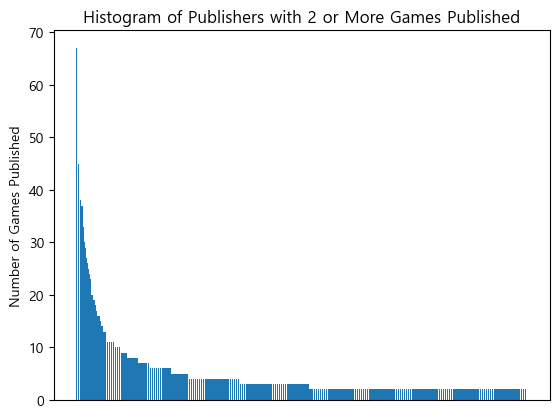

In [23]:
publisher_game_counts = df['publisher'].value_counts()

filtered_publisher_counts = publisher_game_counts[publisher_game_counts >= 2]
plt.bar(range(len(filtered_publisher_counts)), filtered_publisher_counts.values)
plt.ylabel('Number of Games Published')
plt.title('Histogram of Publishers with 2 or More Games Published')
plt.xticks([])
plt.show()

In [24]:
top_5_percent_threshold = filtered_publisher_counts.quantile(0.97)

print("상위 3% 값:", top_5_percent_threshold)

상위 3% 값: 23.569999999999936


In [25]:
def is_big_publisher(x):
    try:
        return filtered_publisher_counts[x] >= top_5_percent_threshold
    except KeyError:
        return False

In [26]:
df['big_publisher'] = df['publisher'].map(is_big_publisher)

In [27]:
df[['appid', 'name', 'publisher', 'big_publisher']].head(3)

,appid,name,publisher,big_publisher
0,10,Counter-Strike,Valve,True
1,20,Team Fortress Classic,Valve,True
2,30,Day of Defeat,Valve,True


### vii. owners 수치형 데이터로 변환

owners의 경우 범위를 나타내는 방법으로 데이터가 저장되어있기 때문에 계산에 적합하지 않음\
이에 따라 정수형 데이터로 변환하는 작업을 진행

In [28]:
df['owners'].value_counts()

owners
200000-500000          1029
100000-200000           974
20000-50000             934
50000-100000            888
0-20000                 720
500000-1000000          422
1000000-2000000         247
2000000-5000000         165
5000000-10000000         42
10000000-20000000        20
20000000-50000000         2
50000000-100000000        2
100000000-200000000       1
Name: count, dtype: int64

In [29]:
def convert_owner_to_int(owner_str):
    values = [int(value) for value in owner_str.split('-')]

    return sum(values) // len(values)

In [30]:
df['owners_int'] = df['owners'].apply(convert_owner_to_int)

In [31]:
df[['appid', 'name', 'owners', 'owners_int']].head(3)

,appid,name,owners,owners_int
0,10,Counter-Strike,10000000-20000000,15000000
1,20,Team Fortress Classic,5000000-10000000,7500000
2,30,Day of Defeat,5000000-10000000,7500000


### vii genres 열 정리 후 genres_info 데이터 프레임으로 변환

In [32]:
unique_genres = set()
for genres in df['genres']:
    unique_genres.update(genres.split(';'))

genre_counts = {}
for genres in df['genres']:
    for genre in genres.split(';'):
        genre_counts[genre] = genre_counts.get(genre, 0) + 1

ram = {}
for index, row in df.iterrows():
    genres = row['genres'].split(';')
    for genre in genres:
        if genre not in ram:
            ram[genre] = row['Min RAM(MB)']

genres_info = pd.DataFrame({'genres': list(genre_counts.keys()),
                            'counts': list(genre_counts.values()),
                            'RAM': [ram[genre] for genre in genre_counts.keys()]})

In [33]:
genres_info

,genres,counts,RAM
0,Action,2724,96.0
1,Free to Play,621,512.0
2,Strategy,1145,4096.0
3,Adventure,2017,2048.0
4,Indie,3559,128.0
5,RPG,1058,64.0
6,Animation & Modeling,11,2048.0
7,Video Production,5,2048.0
8,Simulation,950,1024.0
9,Racing,184,256.0


- Early Access
- Game Development
- Animation & Modeling
- Video Production
- Web Publishing
- Utilities
- Software Training
- Education
- Design & Illustration
- Nudity
- Photo Editing
- Sexual Content
- Audio Production
- Free to play
- Indie	

직접적으로 게임 플레이에 관련된 장르가 아닌 'genres'는 제거

In [34]:
non_game_genres = ['Early Access', 'Game Development', 'Animation & Modeling', 'Video Production', 
                   'Web Publishing', 'Utilities', 'Software Training', 'Education', 
                   'Design & Illustration', 'Nudity', 'Photo Editing', 'Sexual Content', 
                   'Audio Production', 'Free to Play', 'Indie']

genres_info = genres_info[~genres_info['genres'].isin(non_game_genres)]

# III. 기반 데이터 시각화

1차적인 y값인 average_playtime을 y값으로 시각화 진행

## 1. platforms

windows의 경우 모든 게임에서 실행 가능

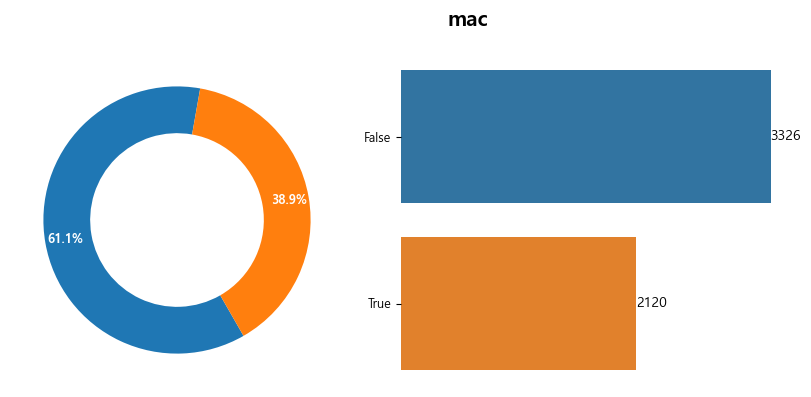

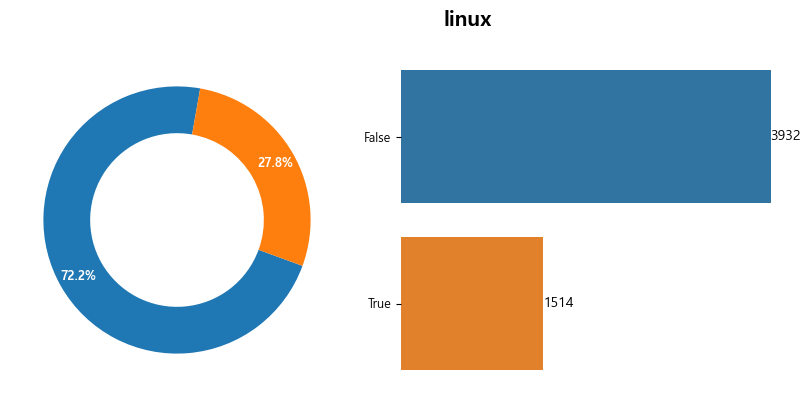

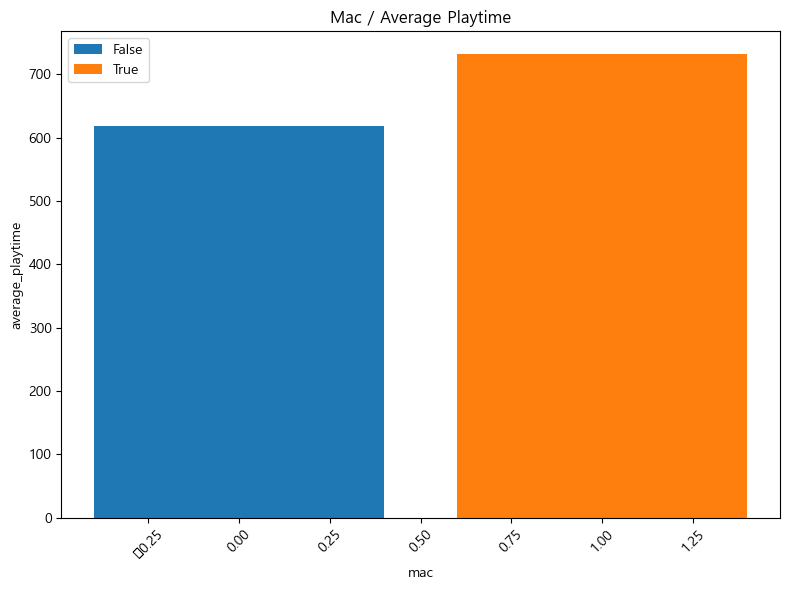

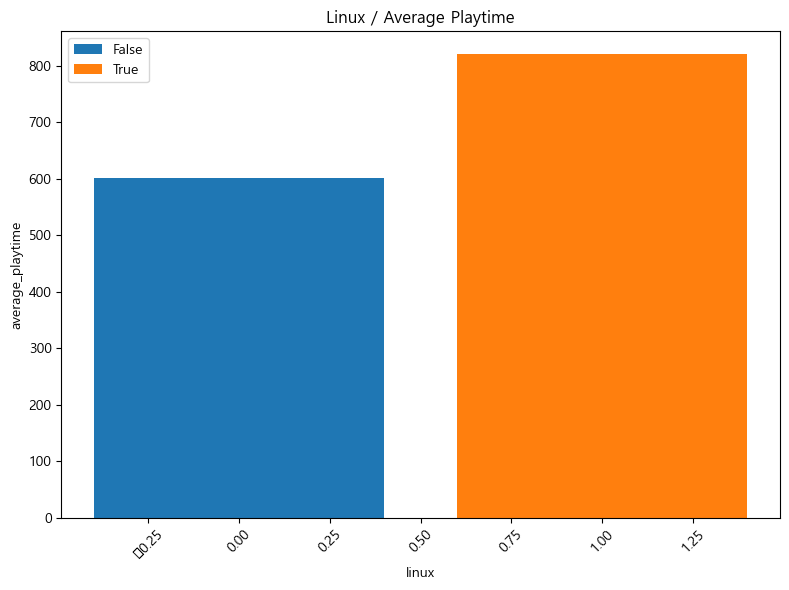

In [35]:
showplot('mac', df)
showplot('linux', df)
vis_data(df, 'mac', 'average_playtime', title = 'Mac / Average Playtime')
vis_data(df, 'linux', 'average_playtime', title = 'Linux / Average Playtime')

## 2. RAM

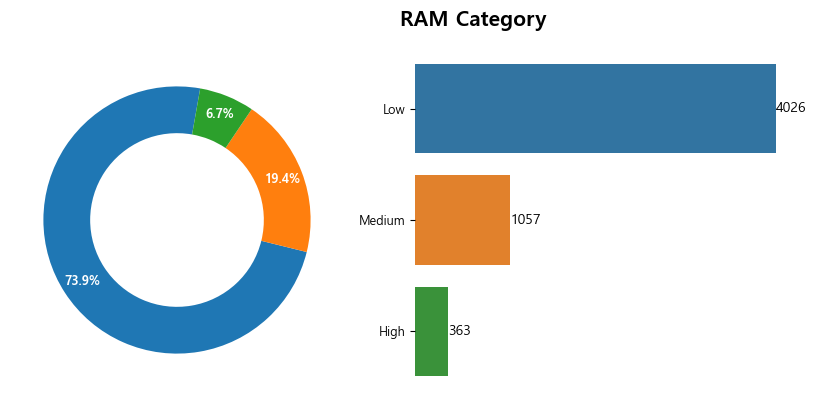

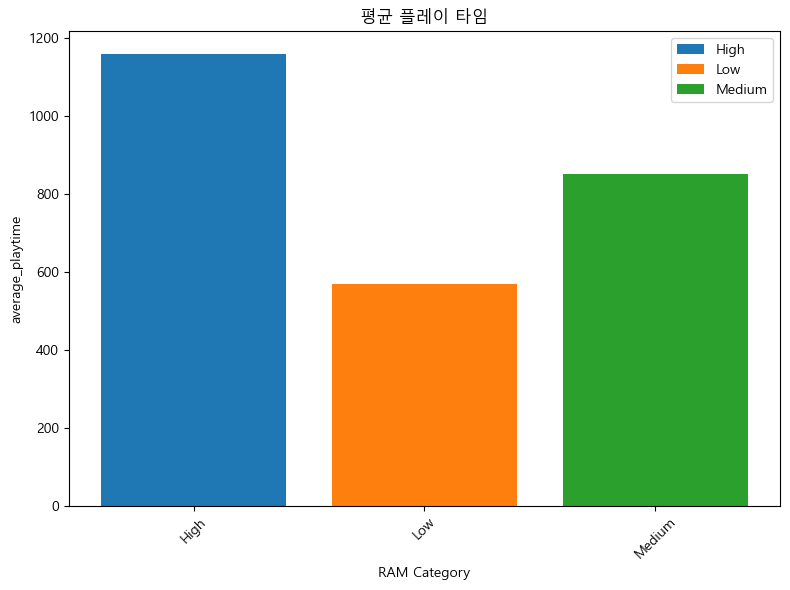

In [36]:
showplot('RAM Category', df)
vis_data(df, 'RAM Category', 'average_playtime', title='평균 플레이 타임')

## 3. isFree

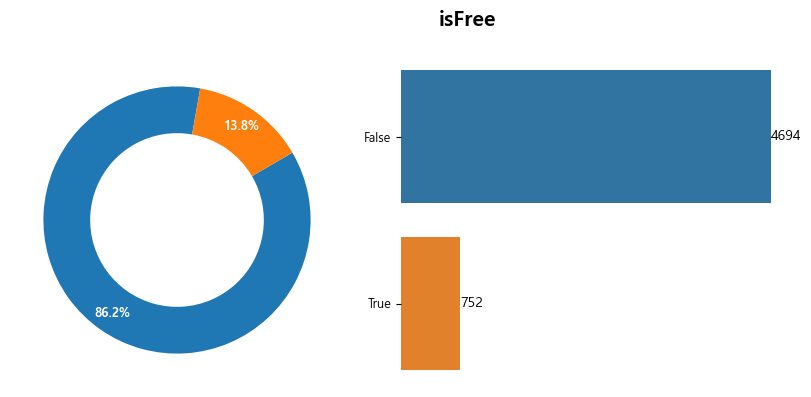

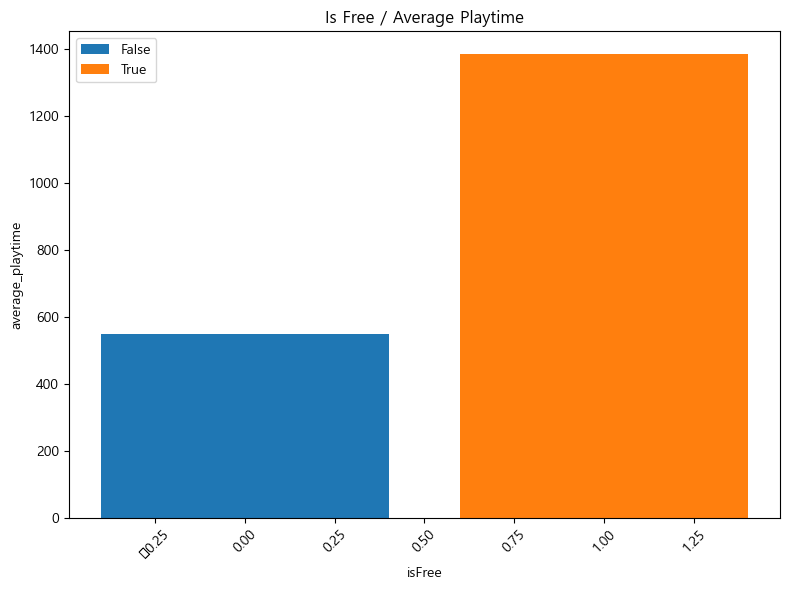

In [37]:
showplot('isFree', df)
vis_data(df, 'isFree', 'average_playtime', title = 'Is Free / Average Playtime')

## 4. age_rating

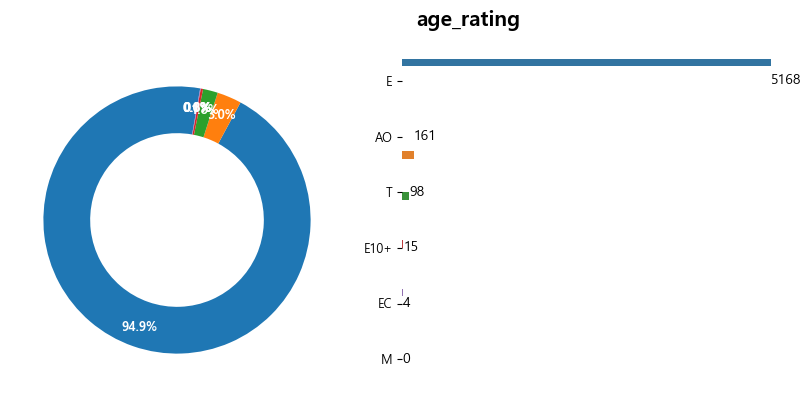

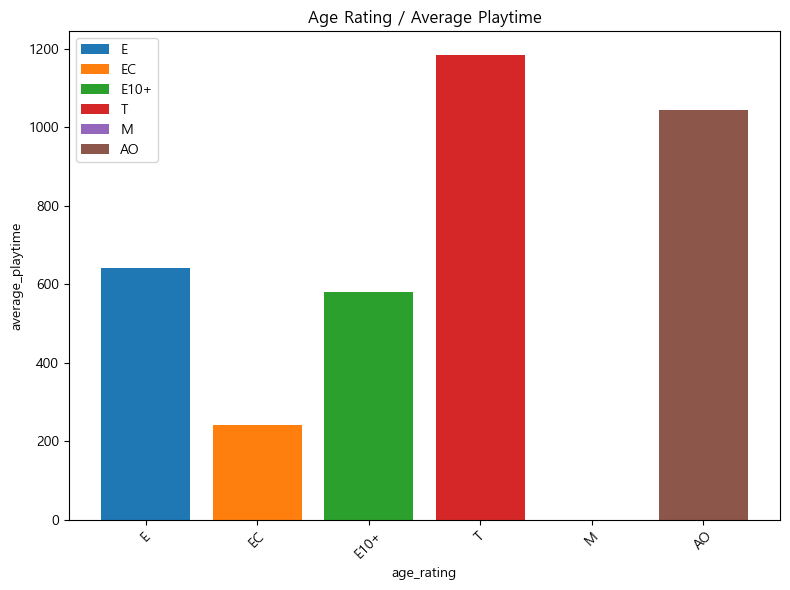

In [38]:
showplot('age_rating', df)
vis_data(df, 'age_rating', 'average_playtime', title = 'Age Rating / Average Playtime')

## 5. positive_ratio

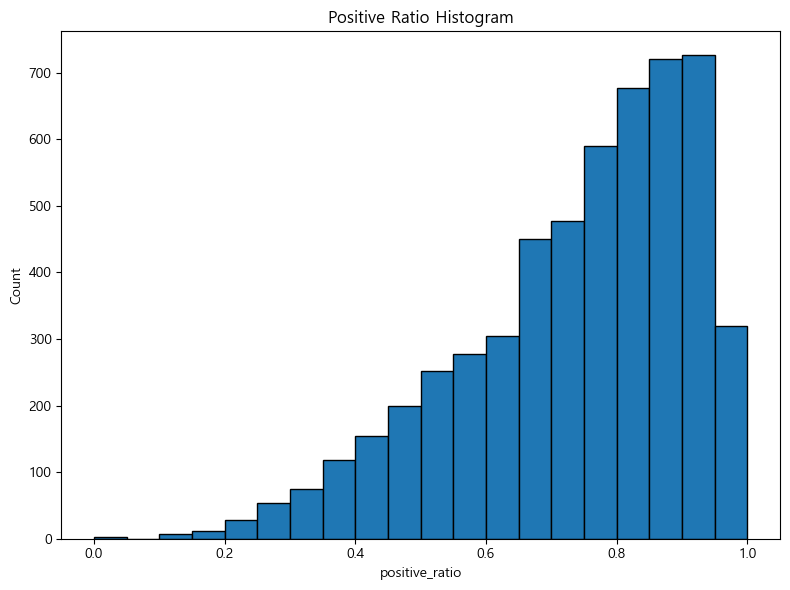

In [39]:
plot_histogram(df, 'positive_ratio', 'Positive Ratio Histogram', 20)

### i. rating_category

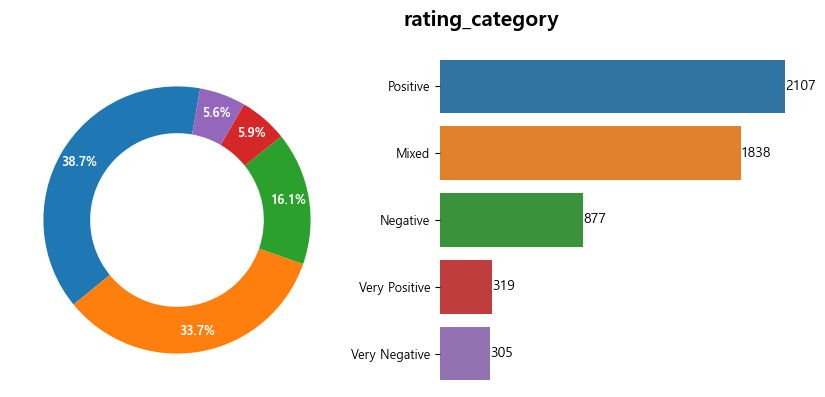

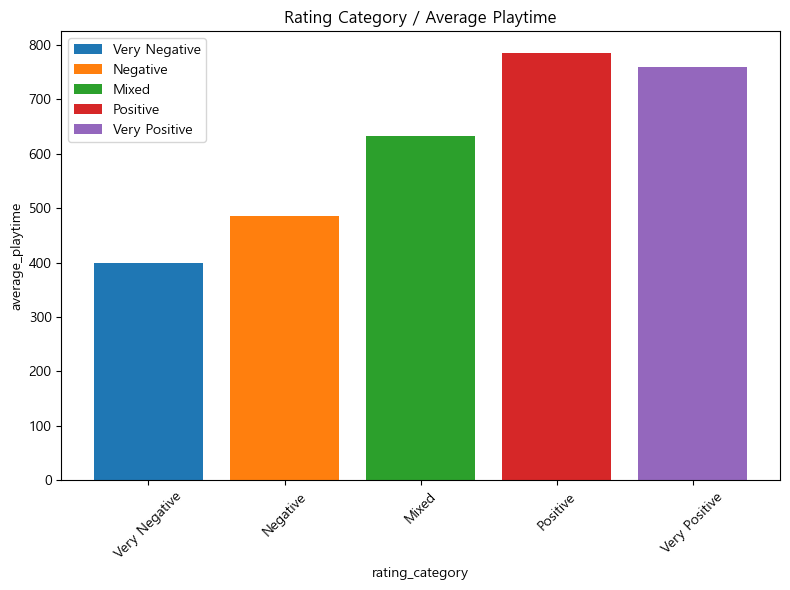

In [40]:
showplot('rating_category', df)
vis_data(df, 'rating_category', 'average_playtime', title='Rating Category / Average Playtime')

## 6. big_publisher

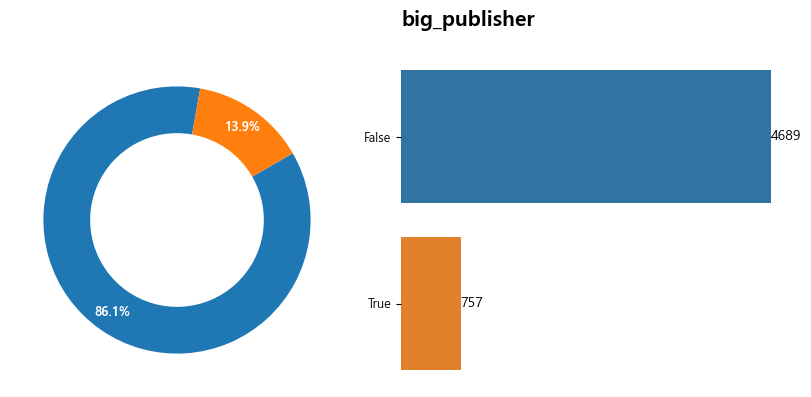

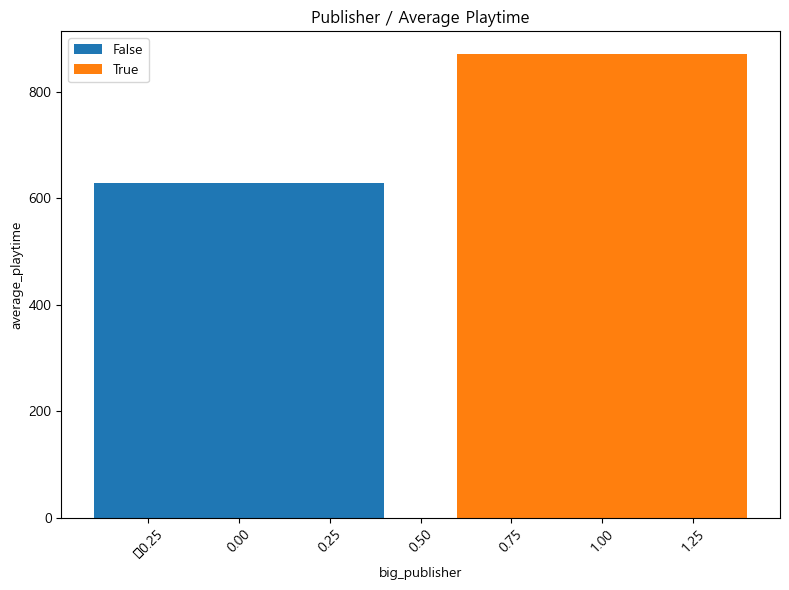

In [41]:
showplot('big_publisher', df)
vis_data(df, 'big_publisher', 'average_playtime', title='Publisher / Average Playtime')

## 7. DataFrame genres_info

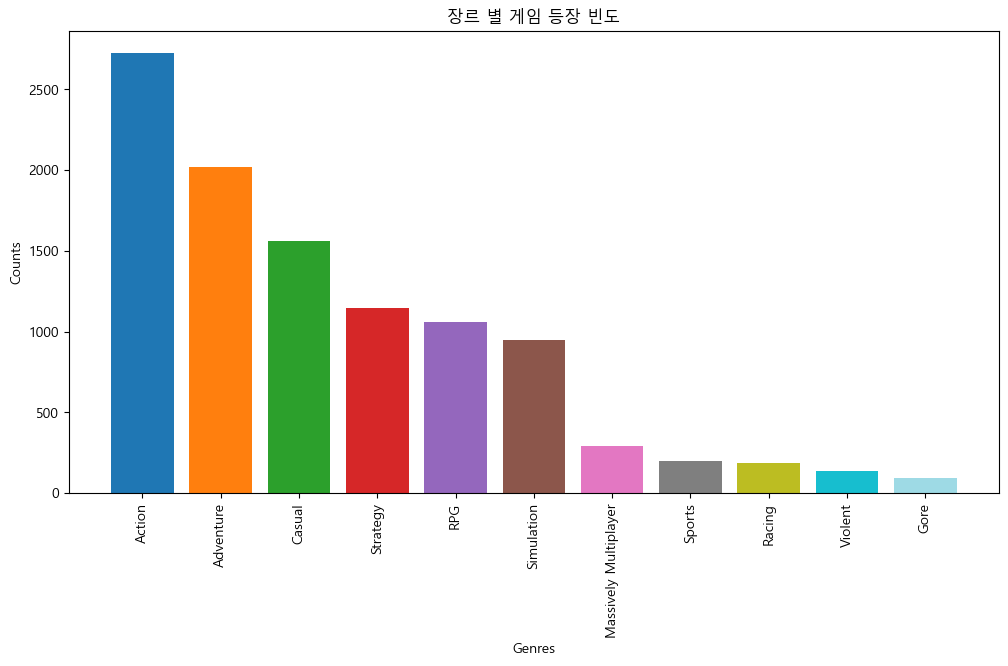

In [42]:
genres_info = genres_info.sort_values(by='counts', ascending=False)

plt.figure(figsize=(12, 6))
colors = plt.cm.tab20(np.linspace(0, 1, len(genres_info)))
plt.bar(genres_info['genres'], genres_info['counts'], color=colors)
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Counts')
plt.title('장르 별 게임 등장 빈도')
plt.show()

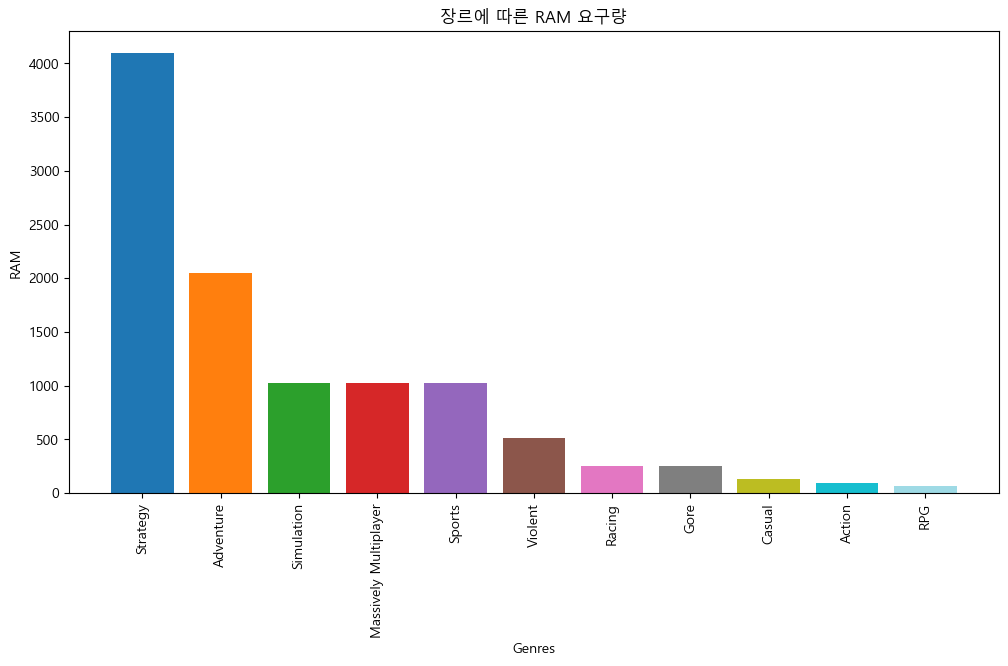

In [43]:
genres_info = genres_info.sort_values(by='RAM', ascending=False)

plt.figure(figsize=(12, 6))
colors = plt.cm.tab20(np.linspace(0, 1, len(genres_info)))
plt.bar(genres_info['genres'], genres_info['RAM'], color=colors)
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('RAM')
plt.title('장르에 따른 RAM 요구량')
plt.show()

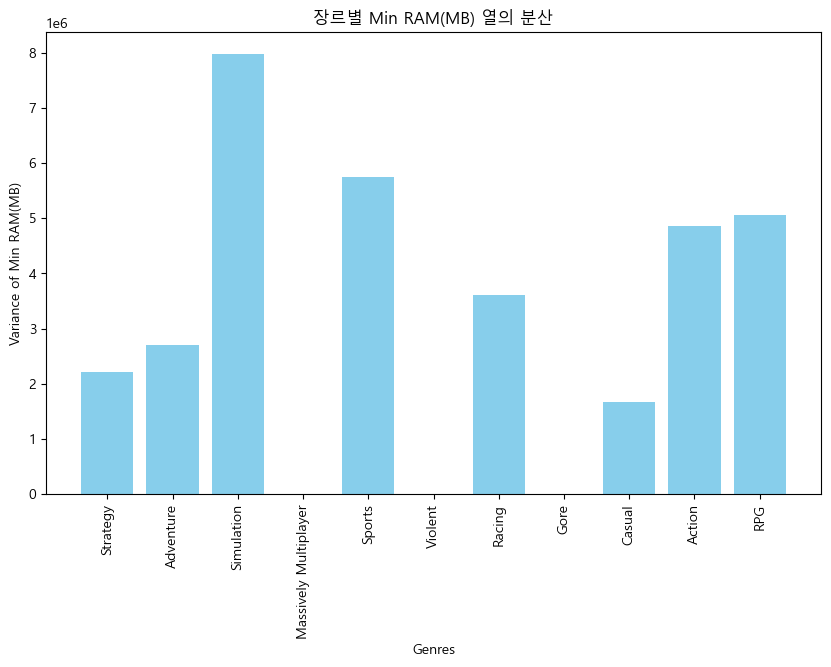

In [44]:
# genres_info 데이터프레임에서 장르 정보를 가져오기
genres_list = genres_info['genres'].tolist()

# 각 장르에 대해 df를 필터링하고 'Min RAM(MB)' 열의 분산 계산
variances = {}
for genre in genres_list:
    genre_df = df[df['genres'].str.contains(genre, regex=False)]
    variance = genre_df.groupby('genres')['Min RAM(MB)'].var().get(genre)
    variances[genre] = variance

# 결과를 데이터프레임으로 변환
variances_df = pd.DataFrame(list(variances.items()), columns=['genres', 'variance'])

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(variances_df['genres'], variances_df['variance'], color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Variance of Min RAM(MB)')
plt.title('장르별 Min RAM(MB) 열의 분산')
plt.show()

# IV. 가설 설정

목표 값은 공통적으로 플레이 타임으로 설정

Owner의 경우 좋은 지표가 될 수 있지만, 값이 정확하지 않고 실제 플레이 유저 수와는 다른 지표이기 때문에 사용하지 않음

## 1. 1차 가설

1. 전략, 어드벤쳐 장르에 한해 요구 사양(RAM Category)의 값이 높을수록 평균 플레이 타임 또한 높을 것이다.
2. 유저의 평가(rating_category)가 높을수록 평균 플레이 타임 또한 높을 것이다.
3. 게임 배급을 많이한 대형 배급사가 배급한 게임이 평균 플레이 타임이 높게 나타날 것이다.

### i. 귀무가설
1. 전략, 어드벤쳐 장르에 한해 요구 사양(RAM Category)의 값이 높을수록 평균 플레이 타임 또한 높다고 할 수 없다.
2. 유저의 평가가 높다고 해서 평균 플레이 타임이 높다고 할 수 없다.
3. 배급사의 크기는 평균 플레이 타임에 영향을 미치지 않는다.

###### ※ 배급사의 크기는 배급한 게임이 2개 이상인 게임사 중 상위 3%를 기준으로 정함

### ii. 설정 배경

#### 1차 - 1번 가설

전략, 어드벤쳐 장르의 경우 사용자 경험과 게임의 질을 높이기 위해선 보다 높은 수준의 컴퓨터 성능이 요구됨\
RAM Category에 따른 average_playtime을 시각화한 결과를 보면 High - Medium - Low - None 순으로 average_playtime이 높게 나타남\
RAM이 Playtime에 영향을 미친다고 가정할 수 있음\
이에 따라 가설을 설정

1번 가설의 경우 filtered_genres가 true인 경우만 데이터 프레임을 분리

In [45]:
df['filtered_genres'] = df['genres'].apply(lambda x: 'adventure' in x.lower() or 'strategy' in x.lower())
filtered_df = df[df['filtered_genres']]

In [46]:
len(filtered_df)

2931

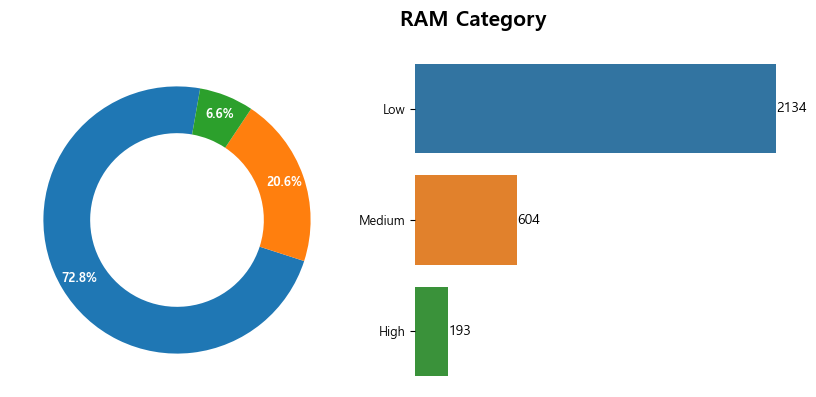

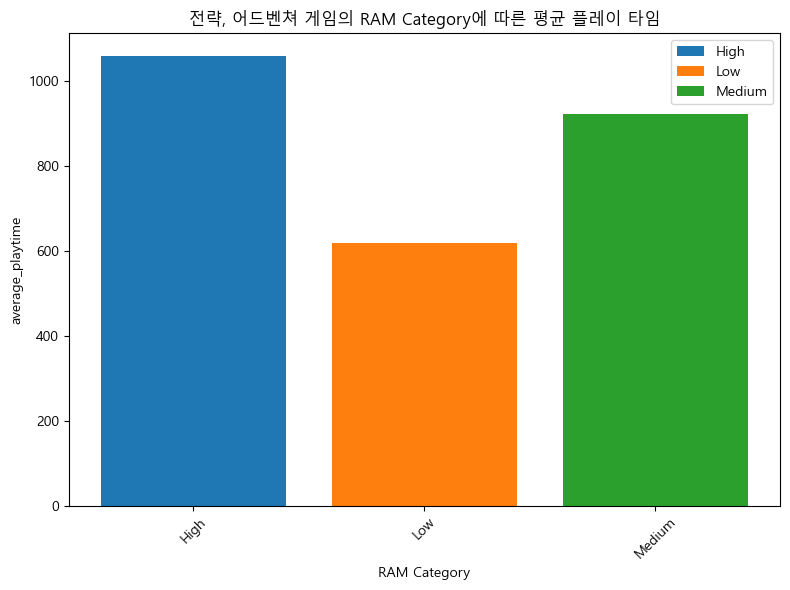

In [47]:
showplot('RAM Category', filtered_df)
vis_data(filtered_df, 'RAM Category', 'average_playtime', '전략, 어드벤쳐 게임의 RAM Category에 따른 평균 플레이 타임')

#### 1차 - 2번 가설

rating_category에 따른 average_playtime을 시각화한 결과를 보면 높은 수준의 평가를 받은 게임이 더 높은 average_playtime을 보이고 있음\
서비스 이용자에게 유저의 평가 지표가 신뢰할 수 있다는 자료를 나타내기 위한 근거 자료로 활용할 여지가 있다고 판단함\
이에 따라 가설을 설정

## 2. 타겟 값(average_playtime) 정규성 검정

x값(RAM Category or rating_category)에 따른 y값이 정규성을 따르는지 확인

검증 결과에 따라 데이터에 맞는 통계적 기법 사용 후 가설 검정

데이터가 정규성을 따르는지 검사하는 is_normal 함수 작성

- QQ Plot
- Histogram
- KDE Plot
- Shapiro-Wilk

In [48]:
def is_normal(df, xlabel, ylabel):
    unique_labels = df[xlabel].unique()
    n_labels = len(unique_labels)
    fig, ax = plt.subplots(n_labels, 3, figsize=(18, 6 * n_labels))

    for i, label in enumerate(unique_labels):
        data = np.array(df.loc[df[xlabel] == label, ylabel])

        qqplot(data, line='s', ax=ax[i][0])
        ax[i][0].set_title(f"QQ Plot: {xlabel} {label}")
        
        sns.histplot(data, kde=False, ax=ax[i][1])
        ax[i][1].set_title(f"Histogram: {xlabel} {label}")
        
        sns.kdeplot(data, ax=ax[i][2])
        ax[i][2].set_title(f"KDE plot: {xlabel} {label}")

        if len(data) < 3:
            print(f"Warning: Data for {xlabel} {label} has less than 3 samples. Skipping Shapiro-Wilk test.")
            continue
        
        _, p_value = shapiro(data)
        print(f'Shapiro-Wilk 검정 결과 (p-value): {xlabel} {label}: {p_value:.5f}')

    plt.tight_layout()
    plt.show()

### i. RAM Category에 따른 정규성 검정

전제 가설에 대해서도 같이 검정 진행

Shapiro-Wilk 검정 결과 (p-value): filtered_genres False: 0.00000
Shapiro-Wilk 검정 결과 (p-value): filtered_genres True: 0.00000


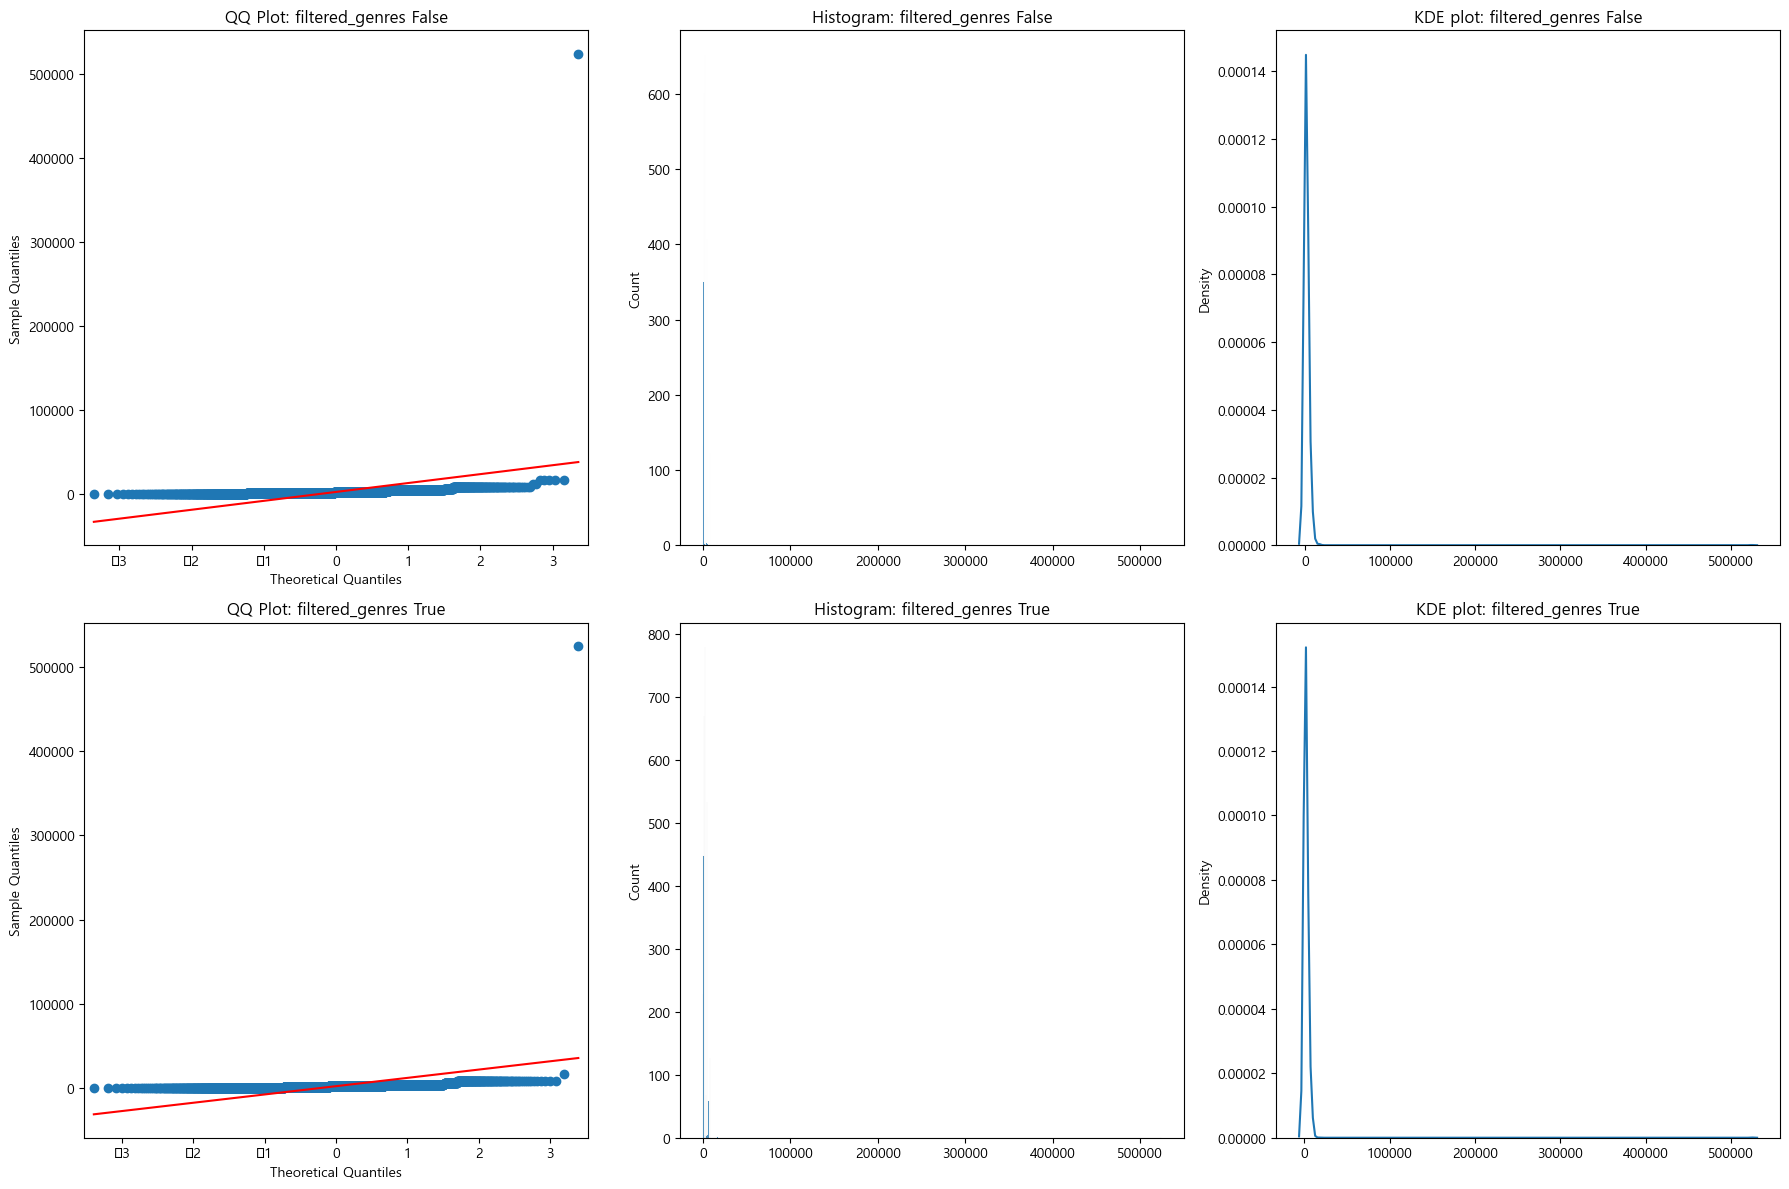

In [49]:
is_normal(df, 'filtered_genres', 'Min RAM(MB)')

Shapiro-Wilk 검정 결과 (p-value): RAM Category Medium: 0.00000
Shapiro-Wilk 검정 결과 (p-value): RAM Category Low: 0.00000
Shapiro-Wilk 검정 결과 (p-value): RAM Category High: 0.00000


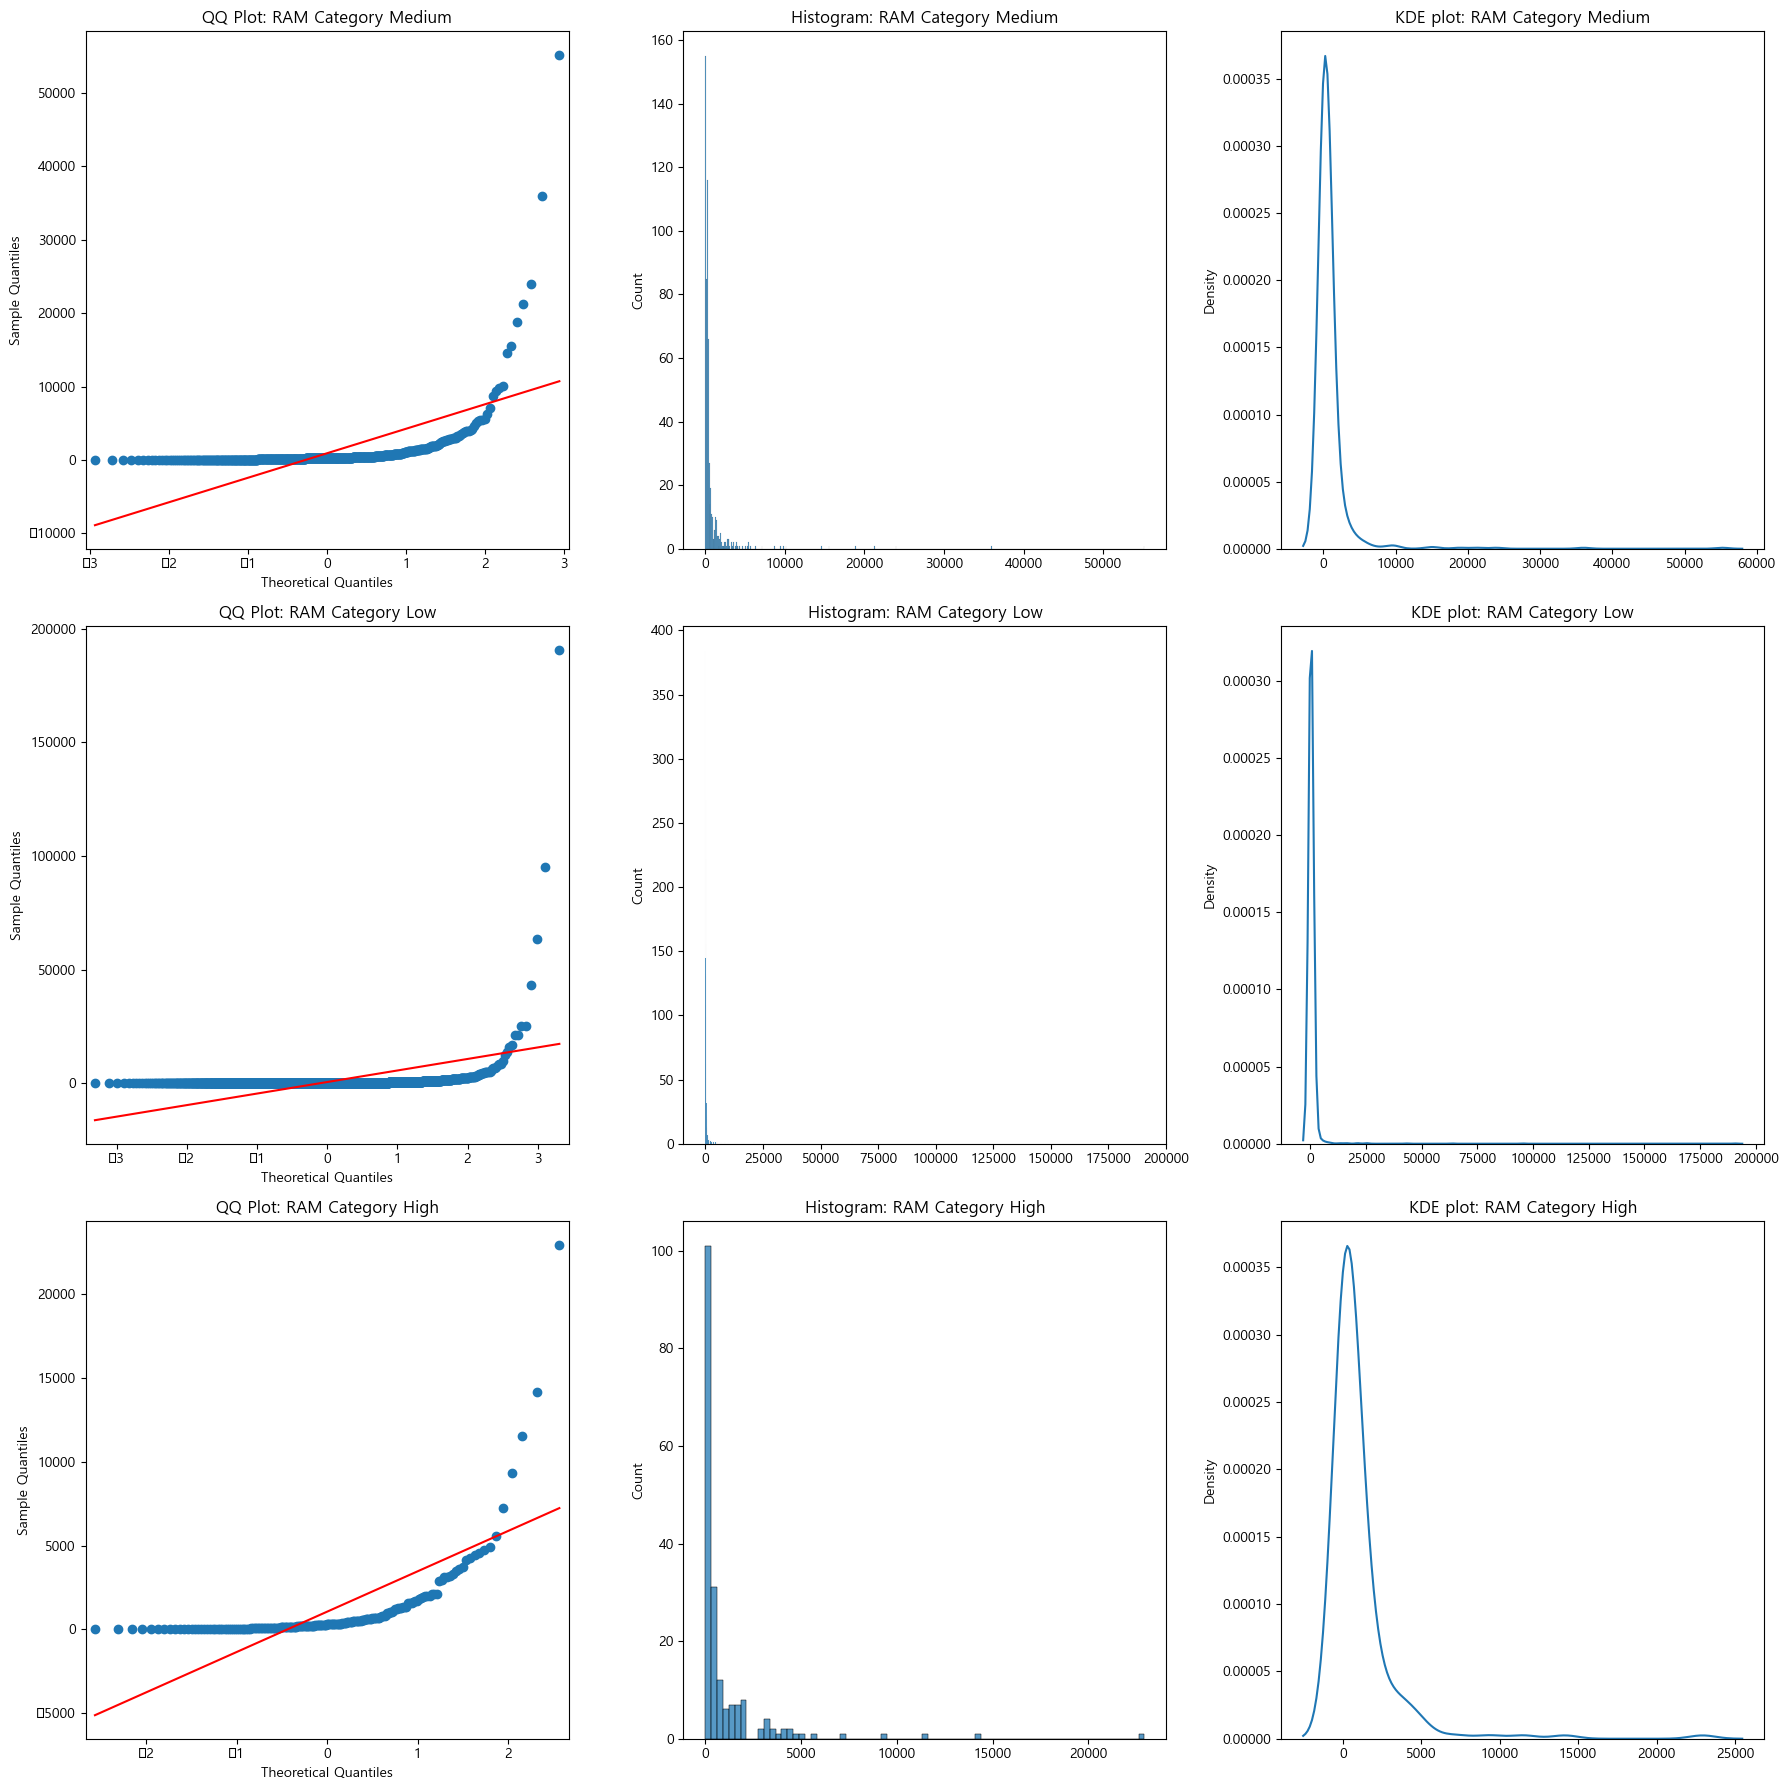

In [50]:
is_normal(filtered_df, 'RAM Category', 'average_playtime')

### ii. rating_category에 따른 정규성 검정

Shapiro-Wilk 검정 결과 (p-value): rating_category Very Positive: 0.00000
Shapiro-Wilk 검정 결과 (p-value): rating_category Positive: 0.00000
Shapiro-Wilk 검정 결과 (p-value): rating_category Mixed: 0.00000
Shapiro-Wilk 검정 결과 (p-value): rating_category Negative: 0.00000
Shapiro-Wilk 검정 결과 (p-value): rating_category Very Negative: 0.00000


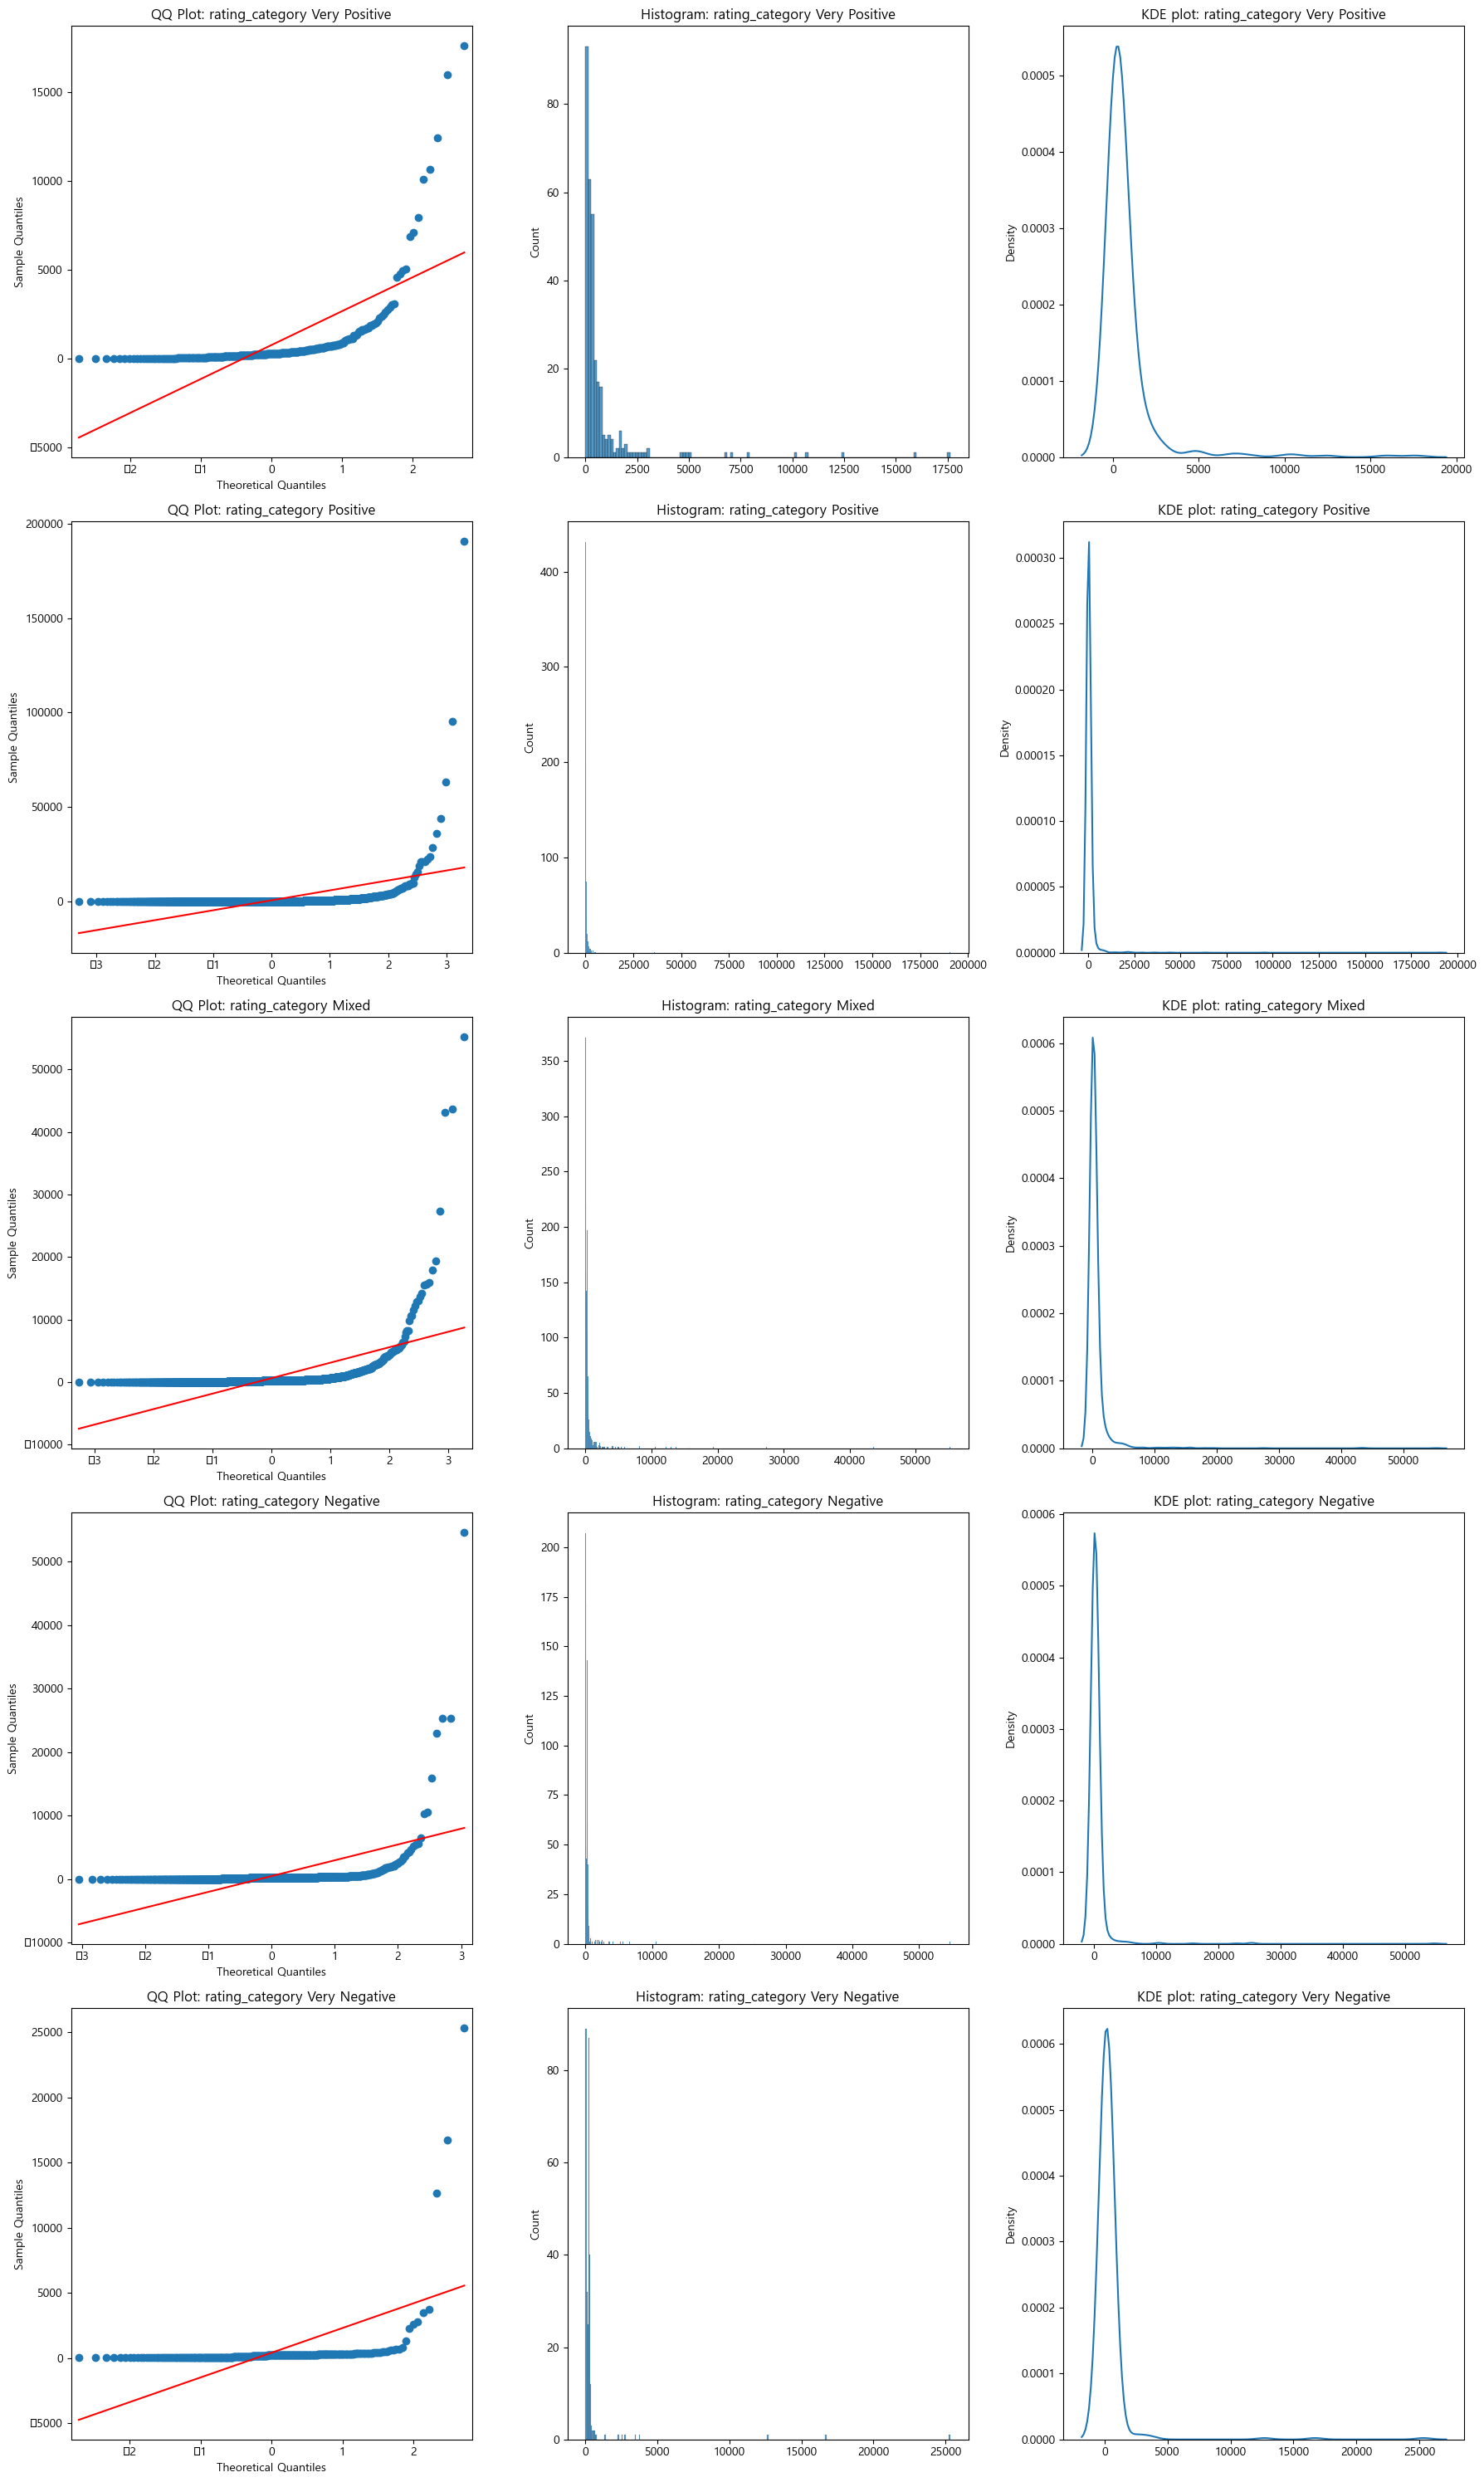

In [51]:
is_normal(df, 'rating_category', 'average_playtime')

### iii. big_publisher에 따른 정규성 검정

Shapiro-Wilk 검정 결과 (p-value): big_publisher True: 0.00000
Shapiro-Wilk 검정 결과 (p-value): big_publisher False: 0.00000


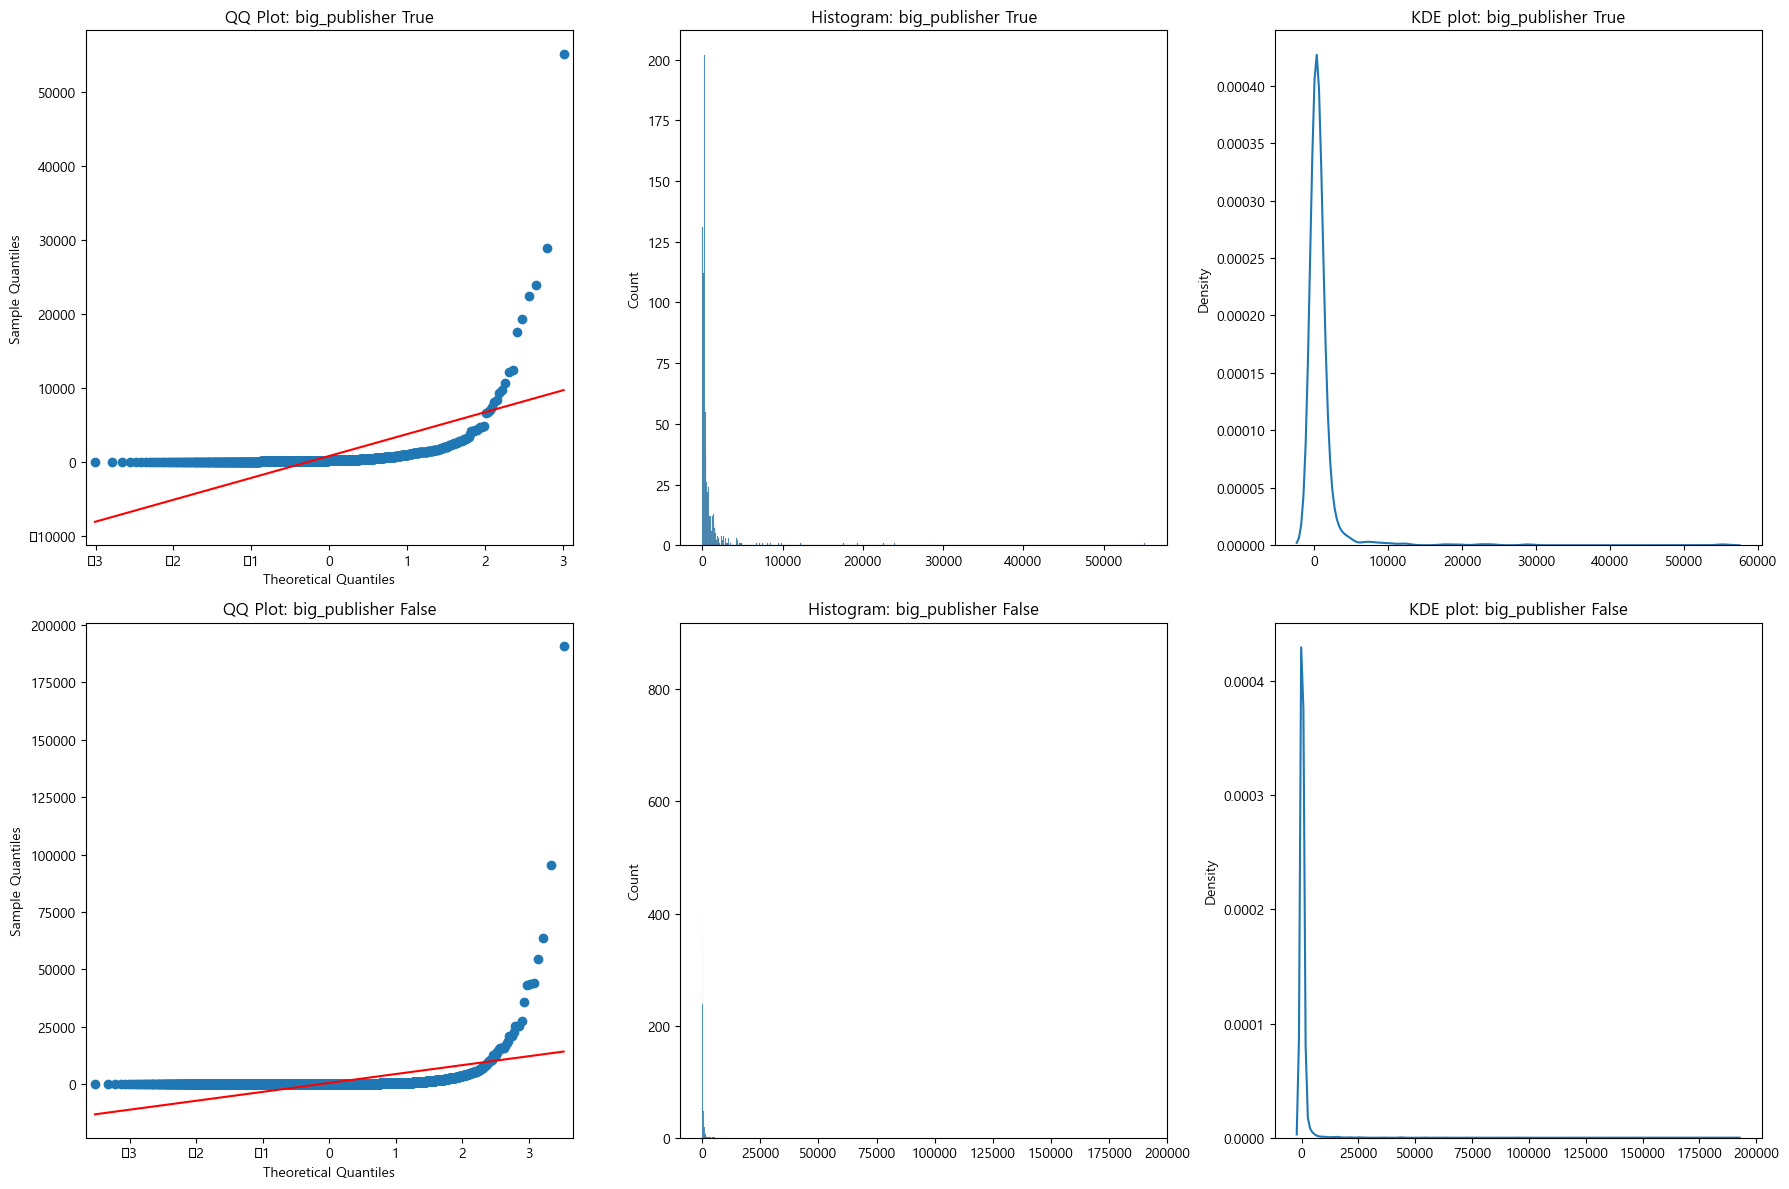

In [52]:
is_normal(df, 'big_publisher', 'average_playtime')

### iv. 정규성 검정 결과

RAM Category, rating_category 그리고 big_publisher에 따른 average_playtime은 모두 정규성을 따르지 않는 것으로 나타남\
이에 따른 검정 방법으로 비모수적 검정 방법을 사용

# V. 가설 검정

1번 가설의 경우 전제 조건인 '전략, 어드벤쳐 게임은 다른 게임보다 요구 RAM의 크기가 평균적으로 더 높다고 할 수 있다.'를 먼저 증명 후 진행 

그룹이 3개 이상인 경우의 가설 검정
- Spearman 상관계수

- Kruskal-Wallis 검정

그룹이 2개인 경우 가설 검정
- Wilcoxon Rank-Sum Test

- Mann-Whitney U-Test

사후 검정

- Dunn's test

## 1. 검정 방법

두 가지 검정 방법을 모두 실행하고 그 결과를 취합 후 사후 검정 진행

### i. Spearman 상관계수

Spearman 상관계수 두 변수 간의 monotonic 관계를 측정하는 비모수 상관계수로 연속형 변수에 적합
- RAM Category의 경우 계산에 사용한 데이터인 Min RAM(MB)을 통해 계산

- rating_category의 경우 계산에 사용한 데이터인 postive_ratio를 통해 계산

In [53]:
def spearman_correlation(x, y):
    corr_coef, p_value = spearmanr(x, y)
    print(f"Spearman's Correlation Coefficient: {corr_coef:.5f}")
    print(f"P-value: {p_value:.5f}")

    # Return 값이 필요하다면 주석 해제
    #return corr_coef, p_value

Spearman 상관계수를 계산하는 함수
    
Args
- x (list): 독립변수 데이터
- y (list): 종속변수 데이터
        
Returns
- corr_coef (float): Spearman 상관계수
- p_value (float): 유의확률

### ii. Kruskal-Wallis 검정

Kruskal-Wallis 검정은 세 개 이상의 그룹 평균 차이를 검정하는 비모수 기법으로, 범주형 변수에 적합

두 가설 모두 x값을 그대로 사용

In [54]:
def kruskal_wallis_test(x, y):
    categories = list(set(x))
    data = [[] for _ in range(len(categories))]
    
    for x_val, y_val in zip(x, y):
        data[categories.index(x_val)].append(y_val)
    
    statistic, p_value = kruskal(*data)

    print(f"Kruskal-Wallis Statistic: {statistic:.5f}")
    print(f"P-value: {p_value:.5f}")

    # Return 값이 필요하다면 주석 해제
    #return statistic, p_value

Kruskal-Wallis 검정을 수행하는 함수
    
Args
- x (list): 독립변수 데이터(범주형)
- y (list): 종속변수 데이터(연속형)
        
Returns
- statistic (float): Kruskal-Wallis 검정통계량
- p_value (float): 유의확률

### iii. Wilcoxon Rank-Sum Test

In [55]:
def wilcoxon_rank_sum_test(y_values, group_col):
    group1 = y_values[group_col == group_col.unique()[0]]
    group2 = y_values[group_col == group_col.unique()[-1]]
    stat, p_value = ranksums(group1, group2)
    
    return stat, p_value

Wilcoxon rank-sum test를 수행하는 함수

Args
- y_values (Series or DataFrame): 종속변수 데이터
- group_col (Series or DataFrame): 그룹 범주

Returns
- stat (float): 검정통계량
- p_value (float): 유의확률

### iv. Mann-Whitney U-Test

In [56]:
def mann_whitney_u_test(y_values, group_col):
    group1 = y_values[group_col == group_col.unique()[0]]
    group2 = y_values[group_col == group_col.unique()[-1]]
    stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
    
    return stat, p_value

Mann-Whitney U test를 수행하는 함수

Args
- y_values (Series or DataFrame): 종속변수 데이터
- group_col (Series or DataFrame): 그룹 범주

Returns
- stat (float): 검정통계량
- p_value (float): 유의확률

### v. Dunn's Test

Kruskal-Wallis 검정 결과에서 그룹 간에 차이가 있다고 나온 후, 구체적으로 어떤 그룹 간에 차이가 있는지를 파악하기 위해 수행

In [57]:
def dunn_posthoc_test(group_labels, data):
    if isinstance(data, pd.DataFrame):
        data = data.values.flatten()
    elif isinstance(data, pd.Series):
        data = data.values
    
    if isinstance(group_labels, pd.DataFrame):
        group_labels = group_labels.values.flatten()
    elif isinstance(group_labels, pd.Series):
        group_labels = group_labels.values
    
    statistic, p_value = kruskal(*[data[group_labels == label] for label in set(group_labels)])
    
    if p_value >= 0.05:
        print("그룹 간 차이가 없음")
        return None
    
    a = pd.DataFrame({'vals': data, 'groups': group_labels})
    posthoc_results = posthoc_dunn(a, 'vals', 'groups', p_adjust='fdr_bh')
    
    return posthoc_results

Dunn's test를 수행하는 함수
    
Args
- data (list): 종속변수 데이터
- group_labels (list): 그룹 레이블
        
Returns
- posthoc_results (DataFrame): 그룹 간 다중비교 결과

## 2. 검정

전제 조건 증명

In [58]:
spearman_correlation(df['filtered_genres'], df['Min RAM(MB)'])

Spearman's Correlation Coefficient: 0.03277
P-value: 0.01558


- Spearman 상관계수: 0.03277 (약한 양의 상관관계)
- p-value: 0.01558 < 0.05 (유의수준)
- 결과: 귀무가설(전략, 어드벤쳐 게임은 다른 게임보다 요구 RAM의 크기가 평균적으로 더 높다고 할 수 없음)을 기각할 근거가 됨
- 해석: 전략, 어드벤쳐 게임은 다른 게임보다 요구 RAM의 크기가 평균적으로 더 높다고 할 수 있다.

In [59]:
kruskal_wallis_test(df['filtered_genres'], df['Min RAM(MB)'])

Kruskal-Wallis Statistic: 5.84867
P-value: 0.01559


- Kruskal-Wallis 통계량: 5.84867
- p-value: 0.01559 < 0.05 (유의수준)
- 결과: 귀무가설(전략, 어드벤쳐 게임은 다른 게임보다 요구 RAM의 크기가 평균적으로 더 높다고 할 수 없음)을 기각할 근거가 됨
- 해석: 전략, 어드벤쳐 게임은 다른 게임보다 요구 RAM의 크기가 평균적으로 더 높다고 할 수 있다.

### i. 1번 가설

#### Spearman 상관계수

In [60]:
spearman_correlation(filtered_df['Min RAM(MB)'], filtered_df['average_playtime'])

Spearman's Correlation Coefficient: 0.11075
P-value: 0.00000


- Spearman 상관계수: 0.11075 (약한 양의 상관관계)
- p-value: 0.00000 < 0.05 (유의수준)
- 결과: 귀무가설(RAM과 평균 플레이 타임 간 상관관계 없음)을 기각할 근거가 됨
- 해석: RAM 요구 사양과 평균 플레이 타임 간에 통계적으로 유의미한 약한 양의 상관관계가 있음

#### Kruskal-Wallis 검정

In [61]:
kruskal_wallis_test(filtered_df['RAM Category'], filtered_df['average_playtime'])

Kruskal-Wallis Statistic: 34.96351
P-value: 0.00000


- Kruskal-Wallis 통계량: 34.96351
- p-value: 0.00000 < 0.05 (유의수준)
- 결과: 귀무가설(RAM 요구 사양에 따른 평균 플레이 타임의 차이 없음)을 기각
- 해석: RAM 요구 사양에 따라 평균 플레이 타임에 통계적으로 유의미한 차이가 있음

#### Dunn's Test

In [62]:
dunn_posthoc_test(filtered_df['RAM Category'], filtered_df['average_playtime'])

,High,Low,Medium
High,1.000000,0.000124,0.397998
Low,0.000124,1.000000,0.000003
Medium,0.397998,0.000003,1.000000


RAM 요구 사양이 High, Medium, Low 범주 간 평균 플레이 타임에 있어서 통계적으로 유의미한 차이가 있음

High > Medium > Low 순서로 평균 플레이 타임이 높아지는 경향을 보임

### ii. 2번 가설

#### Spearman 상관계수

In [63]:
spearman_correlation(df['positive_ratio'], df['average_playtime'])

Spearman's Correlation Coefficient: 0.11102
P-value: 0.00000


- Spearman 상관계수: 0.11102 (약한 양의 상관관계)
- p-value: 0.00000 < 0.05 (유의수준)
- 결과: 귀무가설(유저 평가와 평균 플레이 타임 간 상관관계 없음)을 기각할 근거가 됨
- 해석: 유저 평가와 평균 플레이 타임 간에 통계적으로 유의미한 약한 양의 상관관계가 있음

#### Kruskal-Wallis 검정

In [64]:
kruskal_wallis_test(df['rating_category'], df['average_playtime'])

Kruskal-Wallis Statistic: 73.14403
P-value: 0.00000


- Kruskal-Wallis 통계량: 73.14403
- p-value: 0.00000 < 0.05 (유의수준)
- 결과: 귀무가설(유저 평가 범주에 따른 평균 플레이 타임의 차이 없음)을 기각
- 해석: 유저 평가 범주에 따라 평균 플레이 타임에 통계적으로 유의미한 차이가 있음

#### Dunn's Test

In [65]:
dunn_posthoc_test(df['rating_category'], df['average_playtime'])

,Very Negative,Negative,Mixed,Positive,Very Positive
Very Negative,1.000000e+00,4.701756e-03,0.000002,5.338323e-10,1.205779e-10
Negative,4.701756e-03,1.000000e+00,0.008286,1.572749e-06,3.544030e-07
Mixed,1.593890e-06,8.285567e-03,1.000000,5.779421e-03,1.478057e-04
Positive,5.338323e-10,1.572749e-06,0.005779,1.000000e+00,1.418352e-02
Very Positive,1.205779e-10,3.544030e-07,0.000148,1.418352e-02,1.000000e+00


유저 평가 범주 중 Very Positive와 Positive 범주를 제외한 나머지 범주 간 평균 플레이 타임에 있어서 통계적으로 유의미한 차이가 있음

Very Positive > Positive > Mixed > Negative > Very Negative 순서로 평균 플레이 타임이 높아지는 경향을 보임

### iii. 3번 가설

#### Wilcoxon Rank-Sum Test

In [66]:
wrs_stat, wrs_pvalue = wilcoxon_rank_sum_test(df['average_playtime'], df['big_publisher'])
print(f"Wilcoxon rank-sum test statistic: {wrs_stat:.4f}, p-value: {wrs_pvalue:.4f}")

Wilcoxon rank-sum test statistic: 9.1689, p-value: 0.0000


- Wilcoxon Rank-Sum Test 통계량: 9.1689
- p-value: 0.0000 < 0.05 (유의수준)
- 결과: 귀무가설(배급사의 크기는 평균 플레이 타임에 영향을 미치지 않음)을 기각
- 해석: 배급사의 크기가 평균 플레이 타임에 영향을 미친다고 할 수 있음

#### Mann-Whitney U-Test 

In [67]:
mwu_stat, mwu_pvalue = mann_whitney_u_test(df['average_playtime'], df['big_publisher'])
print(f"Mann-Whitney U test statistic: {mwu_stat:.4f}, p-value: {mwu_pvalue:.4f}")

Mann-Whitney U test statistic: 2142826.5000, p-value: 0.0000


- Mann-Whitney U Test 통계량: 2142826.5000
- p-value: 0.0000 < 0.05 (유의수준)
- 결과: 귀무가설(배급사의 크기는 평균 플레이 타임에 영향을 미치지 않음)을 기각
- 해석: 배급사의 크기가 평균 플레이 타임에 영향을 미친다고 할 수 있음

#### Dunn's Test

In [68]:
dunn_posthoc_test(df['big_publisher'], df['average_playtime'])

,False,True
False,1.000000e+00,4.771484e-20
True,4.771484e-20,1.000000e+00


## 3. 결론

### i. 1번 가설

귀무가설을 기각할 근거가 충분하기 때문에 대립가설을 채택

요구 사양의 값이 높을수록 평균 플레이 타임 또한 높다고 할 수 있다.


### ii. 2번 가설

귀무가설을 기각할 근거가 충분하기 때문에 대립가설을 채택

유저의 평가가 높다고 해서 평균 플레이 타임이 높다고 할 수 있다. 하지만 Very Positive와 Positive의 경우 유의미한 차이를 보인다고 하기 어렵다.

### iii. 3번 가설

귀무가설을 기각할 근거가 충분하기 때문에 대립가설을 채택

배급사의 규모가 크면 평균 플레이 타임이 높게 나타났다.

# VI. 파생 가설 설정

## 1. 파생 가설 설정을 위한 데이터 탐색

### i. RAM Category

RAM Category에 평균 플레이 타임과 중앙값 비교

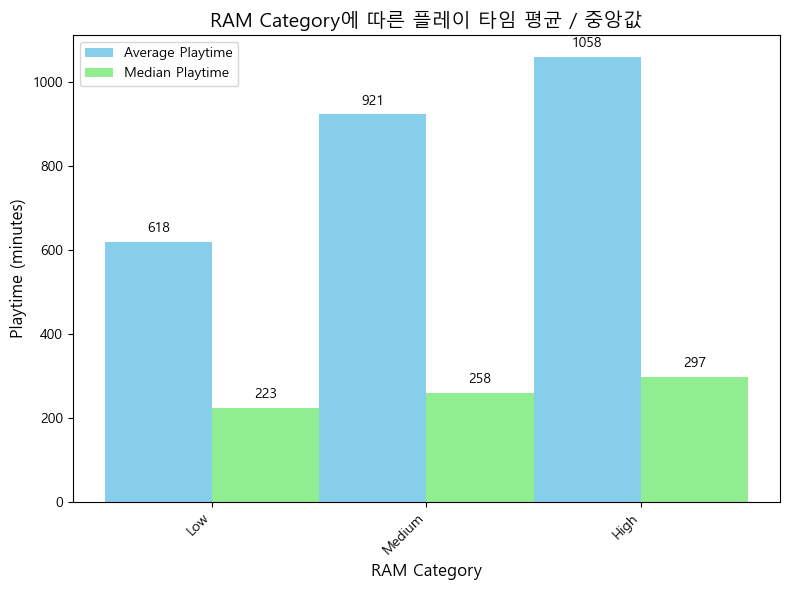

In [69]:
categories = filtered_df['RAM Category'].unique()
average_playtime = [filtered_df.loc[filtered_df['RAM Category']==cat, 'average_playtime'].mean() for cat in categories]
median_playtime = [filtered_df.loc[filtered_df['RAM Category']==cat, 'average_playtime'].median() for cat in categories]

sorted_data = sorted(zip(categories, average_playtime, median_playtime), key=lambda x: x[1])

categories = [item[0] for item in sorted_data]
average_playtime = [item[1] for item in sorted_data]
median_playtime = [item[2] for item in sorted_data]

fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.5
index = np.arange(len(categories))
rects1 = ax.bar(index, average_playtime, bar_width, label='Average Playtime', color='skyblue')
rects2 = ax.bar(index + bar_width, median_playtime, bar_width, label='Median Playtime', color='lightgreen')

ax.set_xlabel('RAM Category', fontsize=12)
ax.set_ylabel('Playtime (minutes)', fontsize=12)
ax.set_title('RAM Category에 따른 플레이 타임 평균 / 중앙값', fontsize=14)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.legend()

for rect1, rect2 in zip(rects1, rects2):
    height1 = rect1.get_height()
    height2 = rect2.get_height()
    ax.annotate(f'{int(height1)}', xy=(rect1.get_x() + rect1.get_width() / 2, height1), xytext=(0, 5), textcoords='offset points', ha='center', va='bottom')
    ax.annotate(f'{int(height2)}', xy=(rect2.get_x() + rect2.get_width() / 2, height2), xytext=(0, 5), textcoords='offset points', ha='center', va='bottom')

plt.tight_layout()
plt.show()

avg_bigger에 플레이 타임의 평균이 중앙값보다 큰 경우를 저장

In [70]:
filtered_df['avg_bigger'] = filtered_df['average_playtime'] > filtered_df['median_playtime']

y값으로 'avg_bigger'를 사용

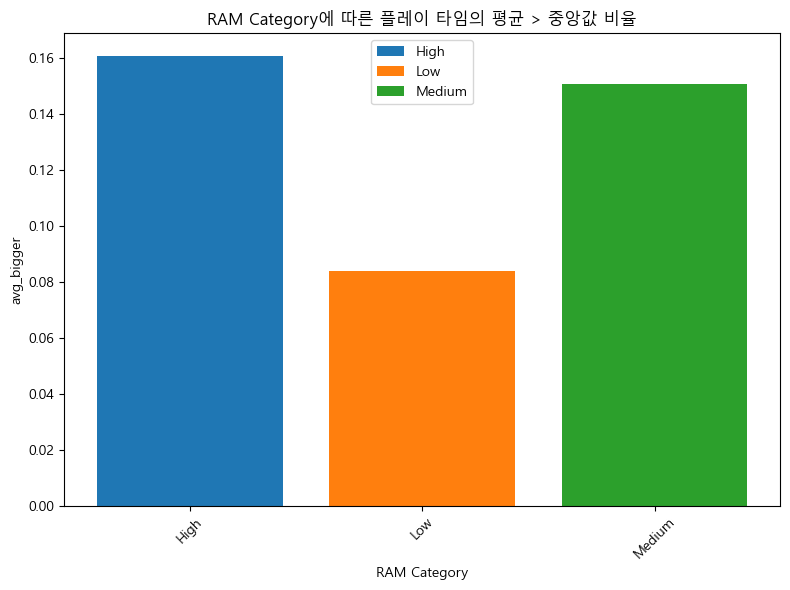

In [71]:
vis_data(filtered_df, 'RAM Category', 'avg_bigger', 'RAM Category에 따른 플레이 타임의 평균 > 중앙값 비율')

### ii. rating_category

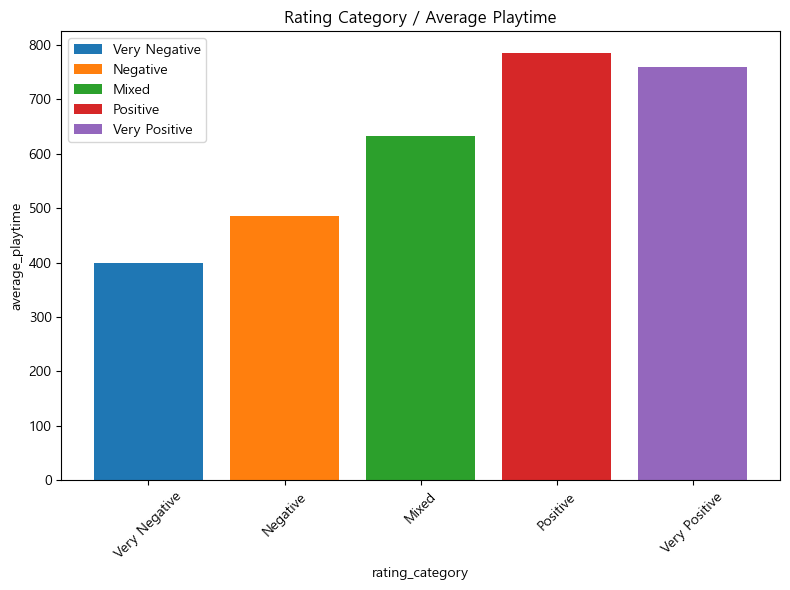

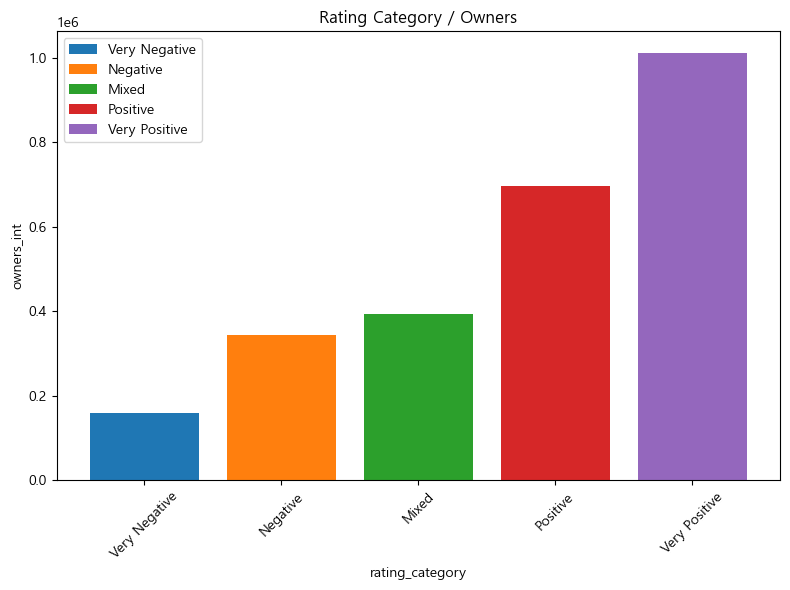

In [72]:
vis_data(df, 'rating_category', 'average_playtime', title='Rating Category / Average Playtime')
vis_data(df, 'rating_category', 'owners_int', title='Rating Category / Owners')

## 2. 파생 가설

1. RAM Category이 높을수록 플레이 타임의 평균이 중앙값보다 높게 나타나는 비율이 높을 것이다.
2. 유저의 평가(rating_category)는 게임의 흥행 성공 여부를 판단하는 결정적인 지표로 작용할 수 있다.

3번 가설은 상위 n% 값을 조절하며 결과가 어떻게 바뀌는지 확인

### i. 귀무가설

1. RAM Category이 높을수록 플레이 타임의 평균이 중앙값보다 높게 나타나는 비율이 높지 않다.
2. 유저의 평가(rating_category)는 게임의 흥행 성공 여부를 판단하는 결정적인 지표로 작용하지 않는다.

### ii. 설정 배경

#### 1번 파생 가설

요구 사양이 높은 게임은 그만큼 게임 플레이에 있어 다양한 선택지를 제공한다고 생각할 수 있고 이에 따라 플레이 타임의 분포가 넓게 나타날 것이라고 예측

#### 2번 파생 가설

Positive와 Very Positive의 차이가 별로 나지 않던 average_playtime과 다르게 owners_int의 경우 큰 차이를 보임

## 3. 타겟 값 정규성 검정

### i. RAM Category에 따른 avg_bigger 정규성 검정

Shapiro-Wilk 검정 결과 (p-value): RAM Category Medium: 0.00000
Shapiro-Wilk 검정 결과 (p-value): RAM Category Low: 0.00000
Shapiro-Wilk 검정 결과 (p-value): RAM Category High: 0.00000


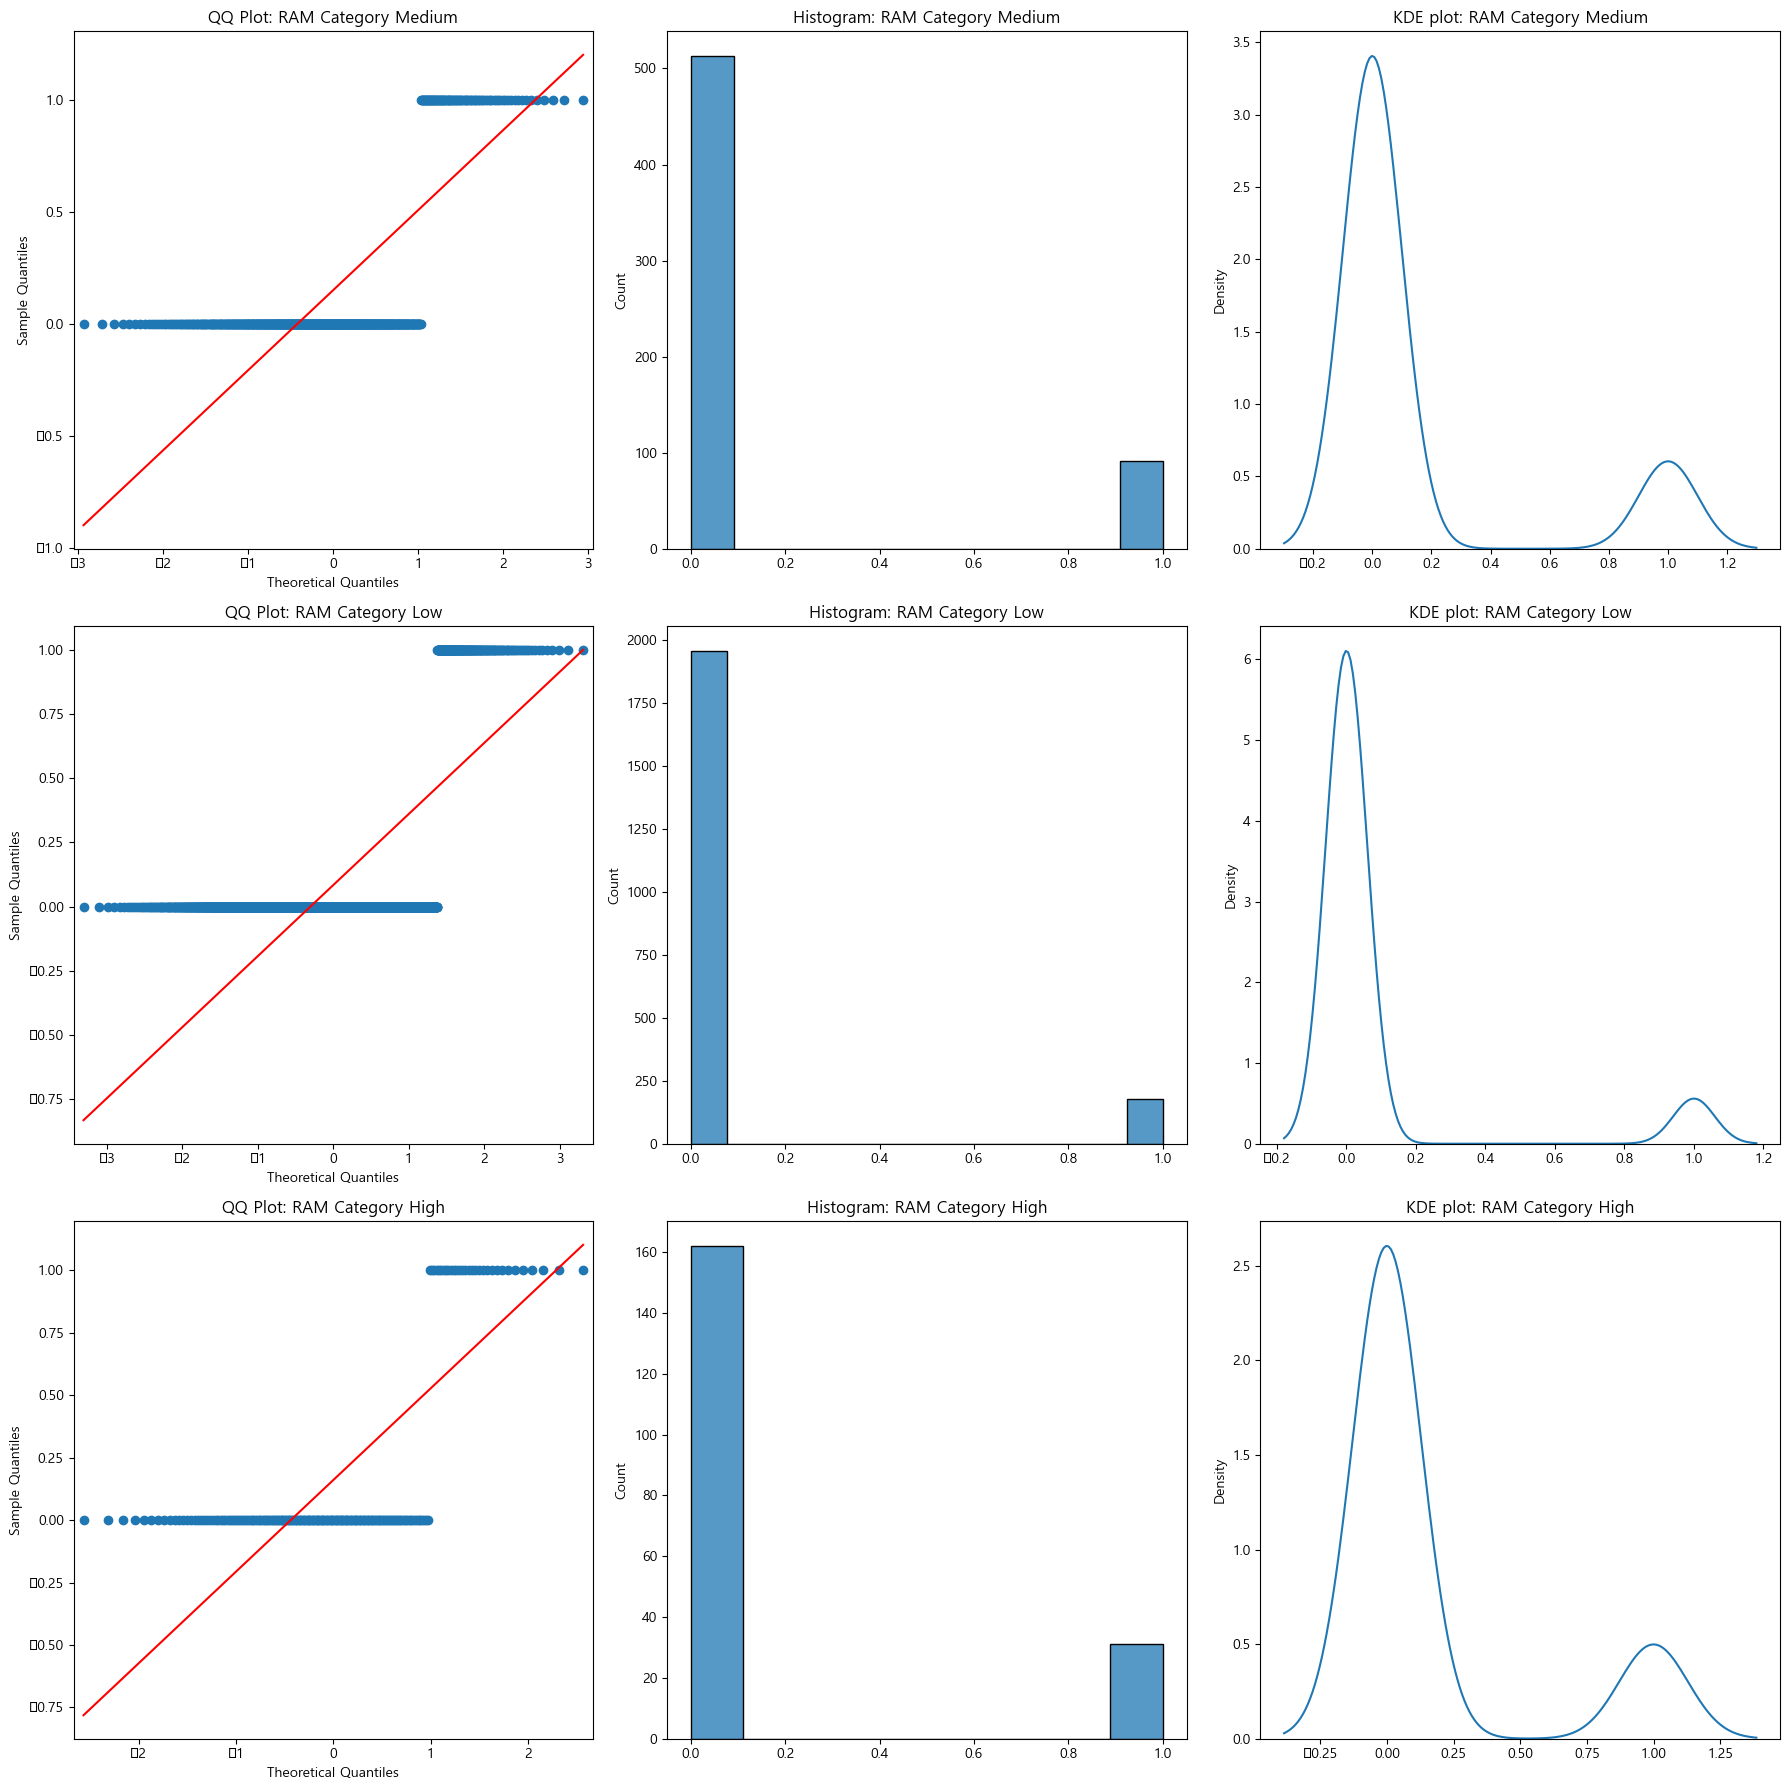

In [73]:
is_normal(filtered_df, 'RAM Category', 'avg_bigger')

### ii. rating_category에 따른 owner_int 정규성 검정

Shapiro-Wilk 검정 결과 (p-value): rating_category Very Positive: 0.00000
Shapiro-Wilk 검정 결과 (p-value): rating_category Positive: 0.00000
Shapiro-Wilk 검정 결과 (p-value): rating_category Mixed: 0.00000
Shapiro-Wilk 검정 결과 (p-value): rating_category Negative: 0.00000
Shapiro-Wilk 검정 결과 (p-value): rating_category Very Negative: 0.00000


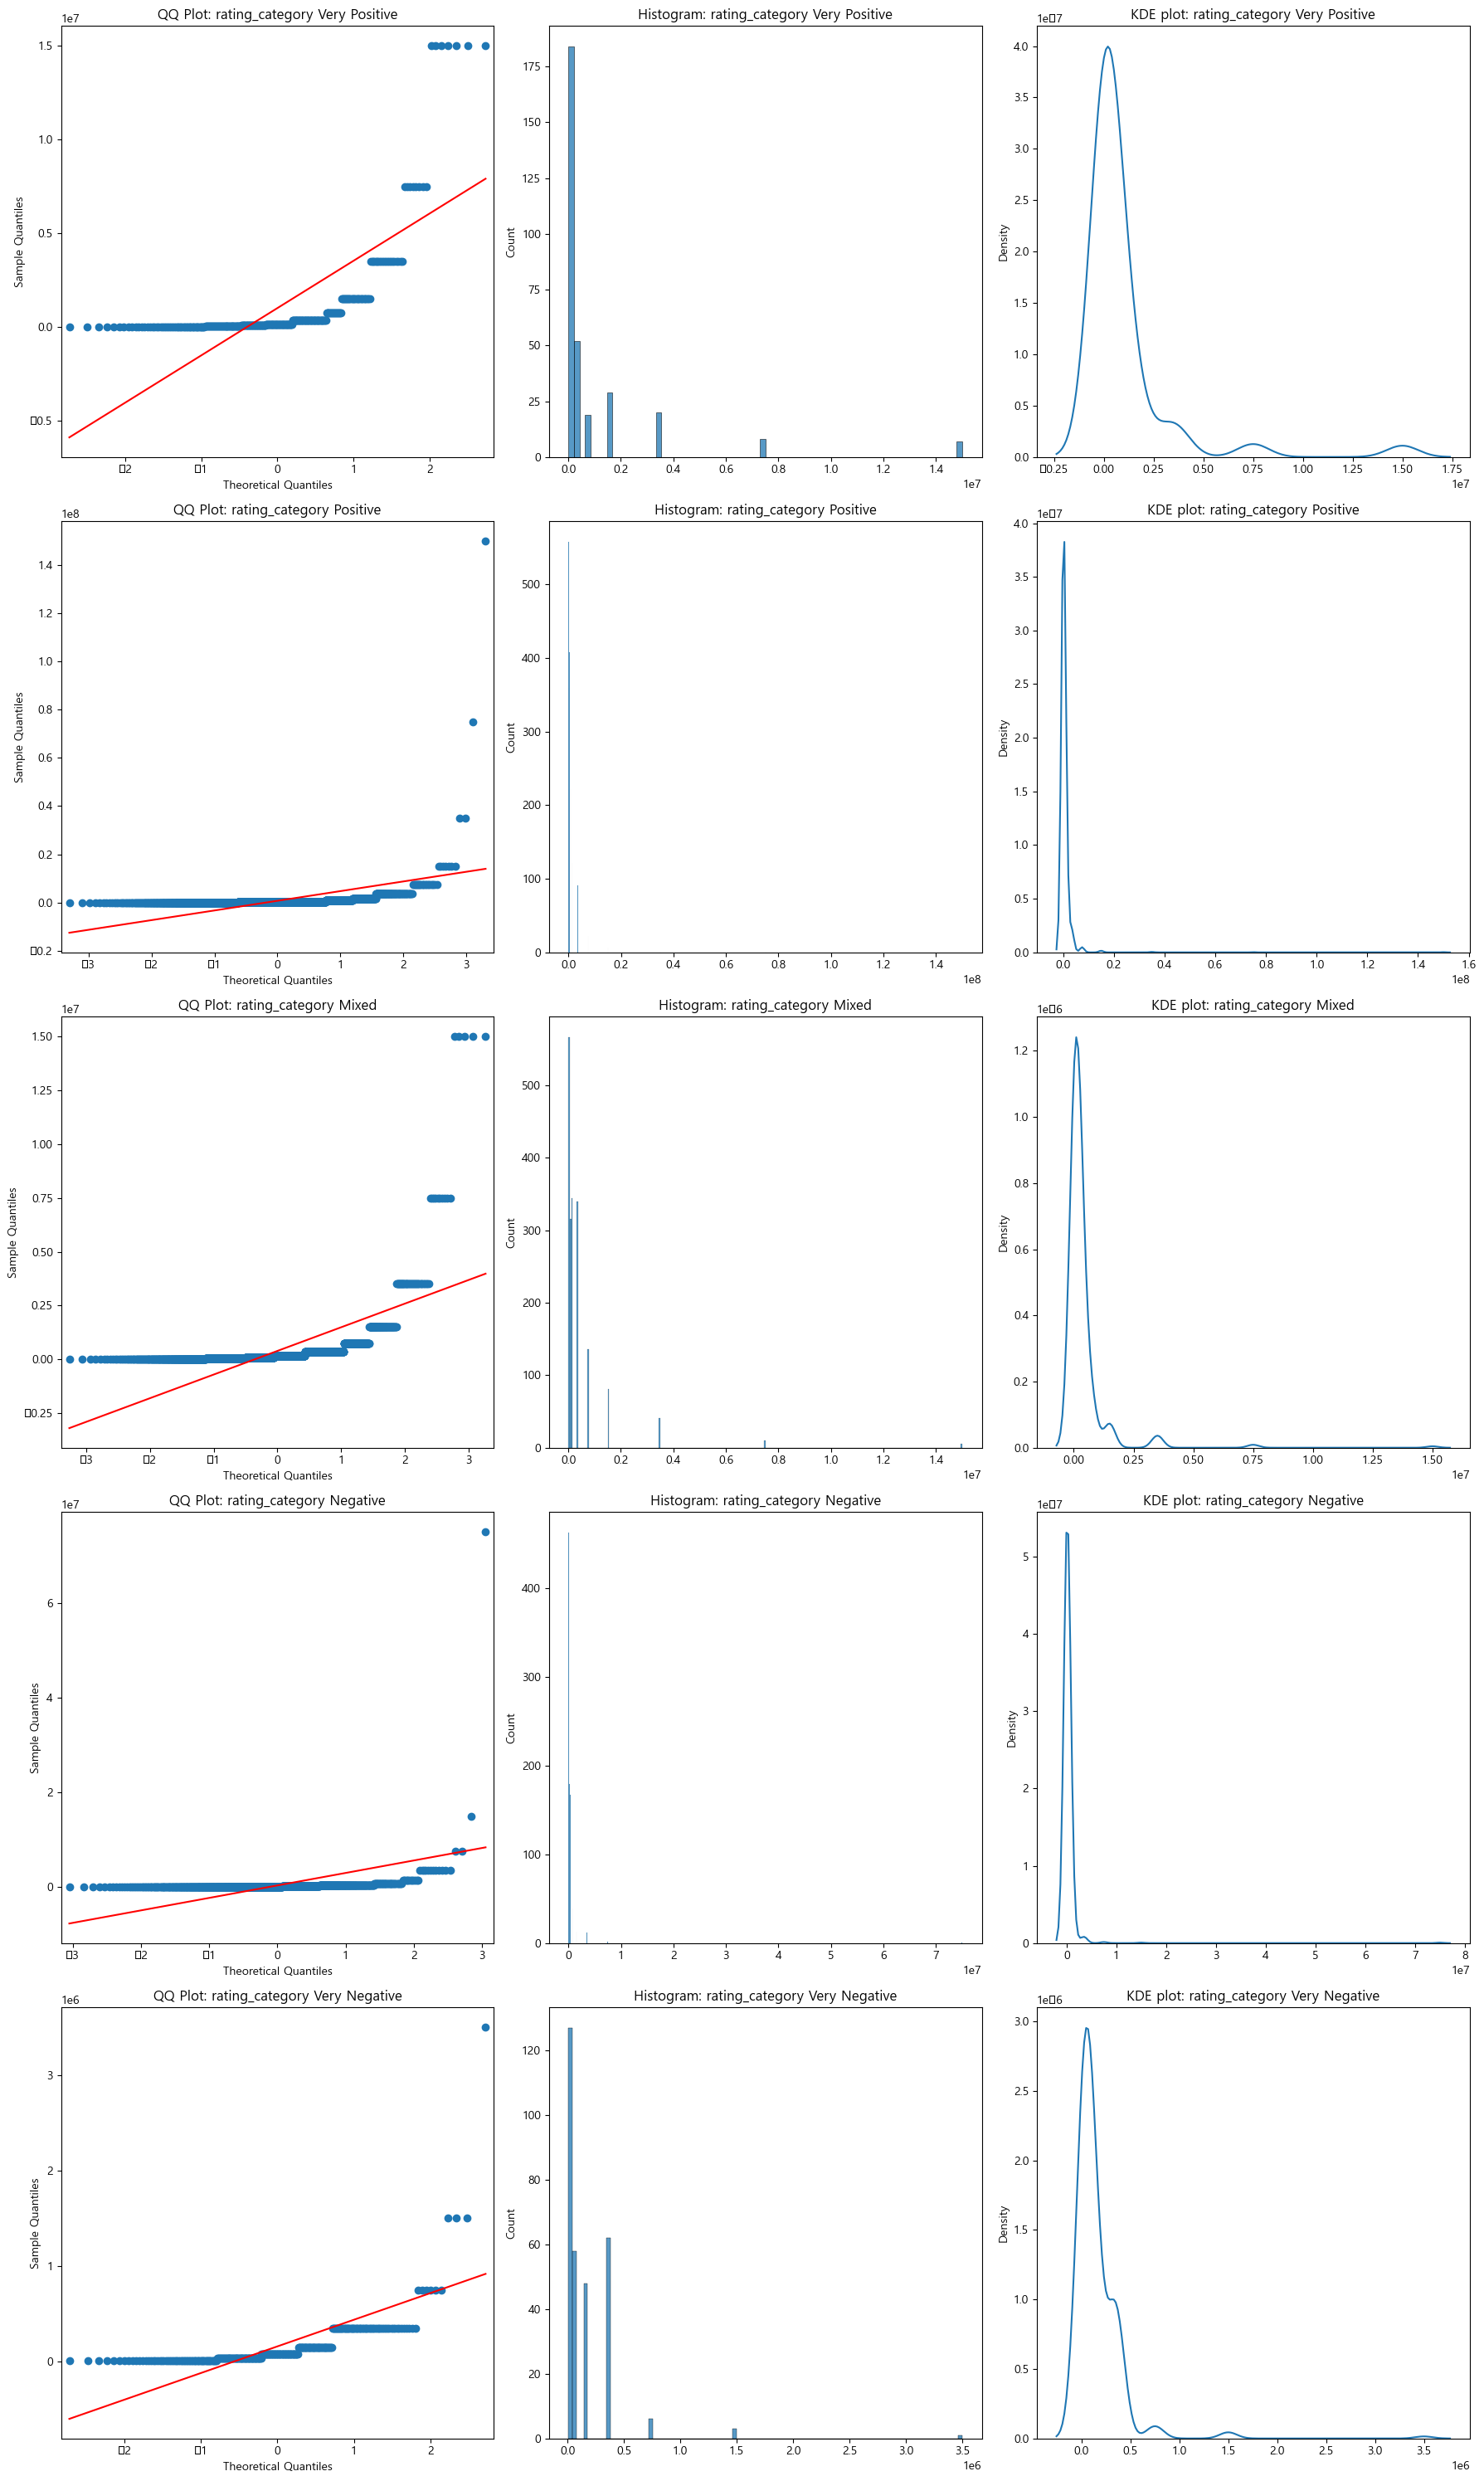

In [74]:
is_normal(df, 'rating_category', 'owners_int')

### iii. 정규성 검정 결과

각 데이터가 전부 정규성을 따르지 않기 때문에 비모수적 검정 방법을 사용

# VII. 파생 가설 검정

## 1. 검정 방법

두 가지 가설의 경우IV(1차 가설 검정) 에서 사용한 것과 동일한 방법 사용

## 2. 검정

### i. 1번 파생 가설

#### Spearman 상관계수

In [75]:
spearman_correlation(filtered_df['Min RAM(MB)'], filtered_df['avg_bigger'])

Spearman's Correlation Coefficient: 0.10771
P-value: 0.00000


- Spearman's Correlation Coefficient: 0.10771(약한 양의 상관관계)
- p-value: 0.00003 < 0.05(유의수준)
- 결과: 귀무가설(RAM Category이 높을수록 플레이 타임의 평균이 중앙값보다 높게 나타나는 비율이 높지 않음)을 기각할 근거가 됨
- 해석: RAM Category이 높을수록 플레이 타임의 평균이 중앙값보다 높게 나타나는 비율이 높음

#### Kruskal-Wallis 검정

In [76]:
kruskal_wallis_test(filtered_df['RAM Category'], filtered_df['avg_bigger'])

Kruskal-Wallis Statistic: 30.29681
P-value: 0.00000


- Kruskal-Wallis Statistic(통계량): 30.29681
- p-value: 0.00002 < 0.05(유의수준)
- 결과: 귀무가설(RAM Category이 높을수록 플레이 타임의 평균이 중앙값보다 높게 나타나는 비율이 높지 않음)을 기각할 근거가 됨
- 해석: RAM Category이 높을수록 플레이 타임의 평균이 중앙값보다 높게 나타나는 비율이 높음

#### Dunn's Test

In [77]:
dunn_posthoc_test(filtered_df['RAM Category'], filtered_df['avg_bigger'])

,High,Low,Medium
High,1.000000,0.001158,0.691572
Low,0.001158,1.000000,0.000005
Medium,0.691572,0.000005,1.000000


High > Medium > Low 순으로 플레이 타임의 평균과 중앙값의 차가 높게 나타남

### ii. 2번 파생 가설

#### Spearman 상관계수

In [78]:
spearman_correlation(df['positive_ratio'], df['owners_int'])

Spearman's Correlation Coefficient: 0.15222
P-value: 0.00000


- Spearman 상관계수: 0.15222 (약한 양의 상관관계)
- p-value: 0.00000 < 0.05 (유의수준)
- 결과: 귀무가설(유저의 평가는 게임의 흥행 성공 여부를 판단하는 결정적인 지표로 작용하지 않음)을 기각할 근거가 됨
- 해석: 유저의 긍정적 평가 비율과 게임을 구매한 유저의 수는 양의 상관관계가 있음

#### Kruskal-Wallis 검정

In [79]:
kruskal_wallis_test(df['rating_category'], df['owners_int'])

Kruskal-Wallis Statistic: 113.54000
P-value: 0.00000


- Kruskal-Wallis 통계량: 113.54000
- p-value: 0.00000 < 0.05 (유의수준)
- 결과: 귀무가설(유저의 평가는 게임의 흥행 성공 여부를 판단하는 결정적인 지표로 작용하지 않음)을 기각할 근거가 됨
- 해석: 유저의 평가와 게임을 구매한 유저의 수는 통계적으로 유의미한 차이가 있음

#### Dunn's Test

In [80]:
dunn_posthoc_test(df['rating_category'], df['owners_int'])

,Very Negative,Negative,Mixed,Positive,Very Positive
Very Negative,1.000000e+00,1.111477e-02,5.025076e-07,8.899088e-15,1.767816e-08
Negative,1.111477e-02,1.000000e+00,5.908919e-04,1.083886e-14,1.187410e-05
Mixed,5.025076e-07,5.908919e-04,1.000000e+00,1.292044e-07,1.584077e-02
Positive,8.899088e-15,1.083886e-14,1.292044e-07,1.000000e+00,6.754391e-01
Very Positive,1.767816e-08,1.187410e-05,1.584077e-02,6.754391e-01,1.000000e+00


Very Positive > Positive > Mixed > Negative > Very Negative 순서로 owner_int의 값이 높아짐\
1차 가설과는 다르게 Very Positive와 Positive의 차이가 나타남

## 3. big_publisher 기준 변경에 따른 결과 변화 확인

상위 1%부터 50%까지 기준을 나눠 반복하는 반복문 작성\
이후 p-value 확인을 통해 결과가 변경되는 지점을 확인

In [81]:
def is_big_publisher_n(x):
    try:
        return filtered_publisher_counts[x] >= percent_threshold
    except KeyError:
        return False

In [82]:
start_percent = 0.99
pre_top_5 = 0
while True:
    percent_threshold = filtered_publisher_counts.quantile(start_percent) 
    df['big_publisher'] = df['publisher'].map(is_big_publisher_n)
    if mwu_pvalue >= 0.05 or wrs_pvalue >= 0.05:
        print(f"변경 지점 : 상위{round(100-start_percent*100,0)}% 값:", round(top_5_percent_threshold,1))
        wrs_stat, wrs_pvalue = wilcoxon_rank_sum_test(df['average_playtime'], df['big_publisher'])
        print(f"Wilcoxon rank-sum test statistic: {wrs_stat:.4f}, p-value: {wrs_pvalue:.4f}")
        mwu_stat, mwu_pvalue = mann_whitney_u_test(df['average_playtime'], df['big_publisher'])
        print(f"Mann-Whitney U test statistic: {mwu_stat:.4f}, p-value: {mwu_pvalue:.4f}")
        break
    elif start_percent <= 0.5:
        print("변화 없음")
        break
    start_percent = start_percent - 0.01

변화 없음


각 기준에 대해 결과의 변화가 없었음

접근 방법을 변경해 새로 접근
- 게임 배급과 제작을 동시에 진행하는 게임사의 게임과 아닌 게임의 차이가 있을 것이다.

### i. 접근 방법 변경 및 가설 설정

접근 방법을 게임 개발과 배급을 동시에 하는 게임사에서 만든 게임으로 변경

In [83]:
# 배급한 게임이 1개인 경우
publishers_to_compare = df['publisher'].value_counts()[df['publisher'].value_counts() == 1].index

df['developer_publisher_match'] = df.apply(lambda row: row['developer'] == row['publisher'] if row['publisher'] in publishers_to_compare else False, axis=1)

In [84]:
# 배급한 게임이 2개 이상인 경우
publishers_to_compare = df['publisher'].value_counts()[df['publisher'].value_counts() > 1].index

df['developer_publisher_match_two'] = df.apply(lambda row: row['developer'] == row['publisher'] if row['publisher'] in publishers_to_compare else False, axis=1)

In [85]:
df['developer_publisher_match'].value_counts()

developer_publisher_match
False    3917
True     1529
Name: count, dtype: int64

In [86]:
df['developer_publisher_match_two'].value_counts()

developer_publisher_match_two
False    4030
True     1416
Name: count, dtype: int64

약 1100개의 배급사가 단 하나의 게임에 대해서 제작과 배급을 동시에 하는 것을 확인\
1100개의 배급사는 2개 이상의 게임을 직접 제작하고 배급까지 진행

위 데이터를 바탕으로 시각화 진행

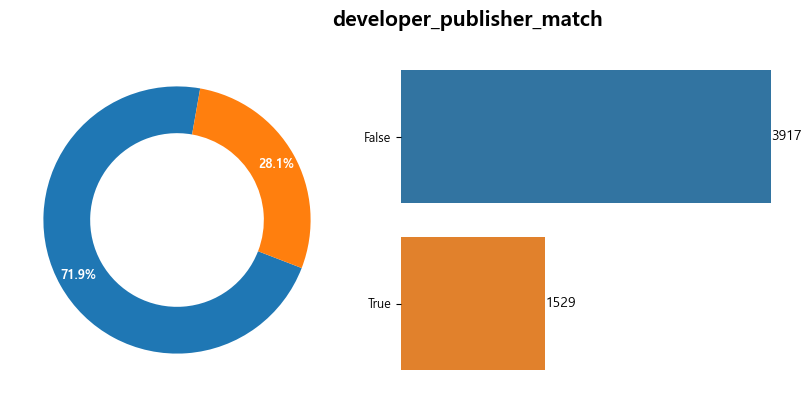

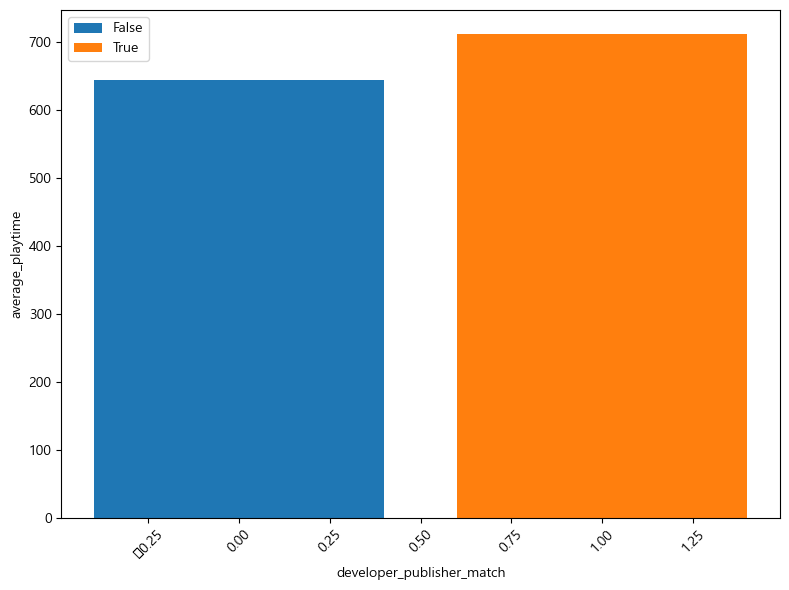

In [87]:
showplot('developer_publisher_match', df)
vis_data(df, 'developer_publisher_match', 'average_playtime')

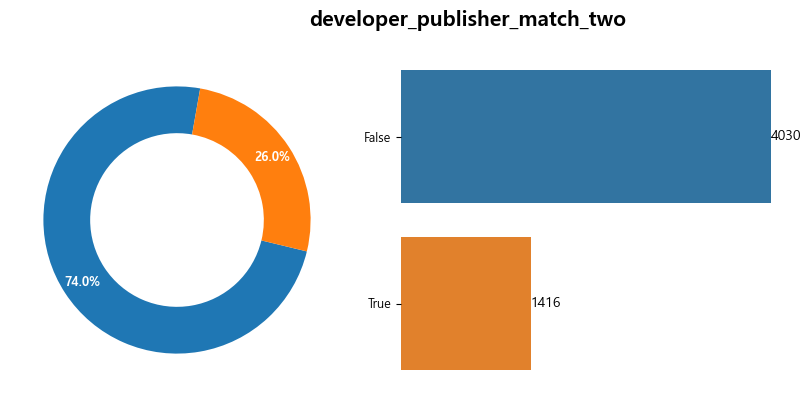

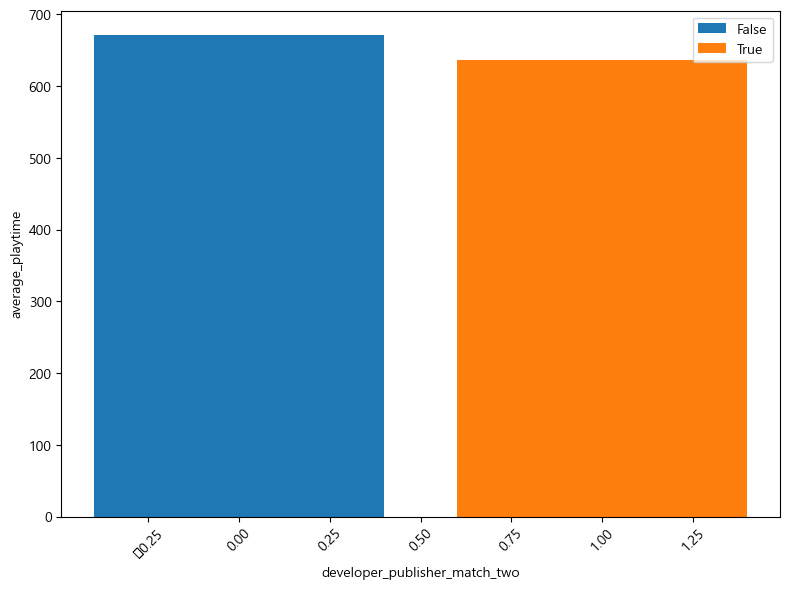

In [88]:
showplot('developer_publisher_match_two', df)
vis_data(df, 'developer_publisher_match_two', 'average_playtime')

게임을 하나만 만들고 배급까지 진행한 게임들의 플레이 타임과\
게임을 두개 이상 만들고 배급까지 진행한 게임들의 플레이 타임의 평균이 전혀 다르게 나타남

- 게임을 하나만 배급한 배급사 중에서 게임을 직접 만들고 배급한 배급사의 게임의 플레이 타임이 더 높을 것이다.

귀무가설
- 게임을 하나만 배급한 배급사 중에서 게임을 직접 만들고 배급한 배급사의 게임의 플레이 타임이 더 높다고 할 수 없다.

### ii. 가설 검정

#### 정규성 검정

Shapiro-Wilk 검정 결과 (p-value): developer_publisher_match False: 0.00000
Shapiro-Wilk 검정 결과 (p-value): developer_publisher_match True: 0.00000


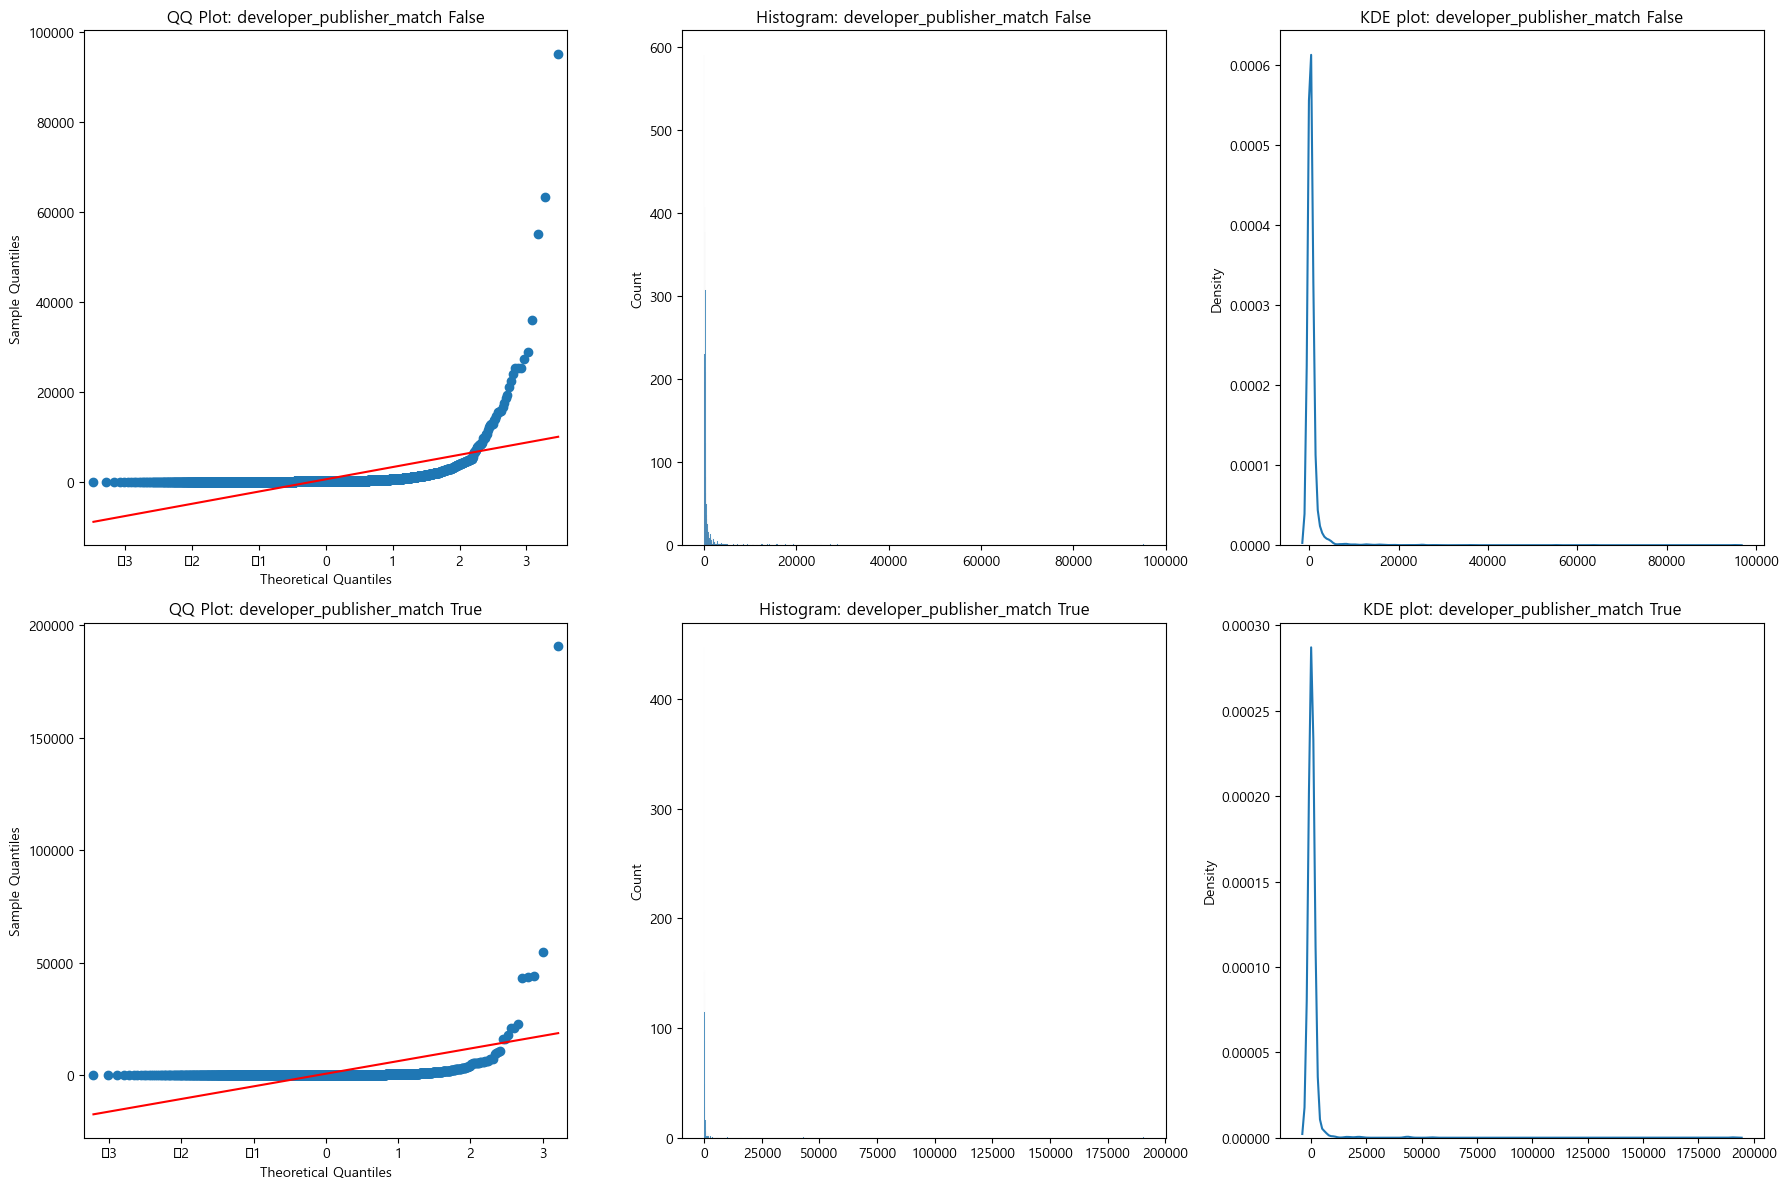

In [89]:
is_normal(df, 'developer_publisher_match', 'average_playtime')

데이터가 정규성을 따르지 않기 때문에 이전에 사용했던 비모수적 검정 방법 그대로 사용

#### 검정

#### Spearman 상관계수

In [90]:
spearman_correlation(df['developer_publisher_match'], df['average_playtime'])

Spearman's Correlation Coefficient: -0.12814
P-value: 0.00000


- Spearman 상관계수: -0.12814 (약한 음의 상관관계)
- p-value: 0.00000 < 0.05 (유의수준)
- 결과: 귀무가설(게임을 하나만 배급한 배급사 중에서 게임을 직접 만들고 배급한 배급사의 게임의 플레이 타임이 더 높다고 할 수 없음)을 기각할 근거가 됨
- 해석: 게임 제작과 배급을 같이하는 경우 플레이 타임이 유의미하게 높게 나타남

#### Kruskal-Wallis 검정

In [91]:
kruskal_wallis_test(df['developer_publisher_match'], df['average_playtime'])

Kruskal-Wallis Statistic: 89.40480
P-value: 0.00000


- Kruskal-Wallis 통계량: 89.40480
- p-value: 0.00000 < 0.05 (유의수준)
- 결과: 귀무가설(게임을 하나만 배급한 배급사 중에서 게임을 직접 만들고 배급한 배급사의 게임의 플레이 타임이 더 높다고 할 수 없음)을 기각할 근거가 됨
- 해석: 게임 제작과 배급을 같이하는 경우 플레이 타임이 유의미하게 높게 나타남

# VIII. 결론

## 1. 요구 사양(RAM)과 평균 플레이 타임의 관계

### i. 1차 가설

전략, 어드벤처 장르의 게임에 대해서  요구 사양(RAM Category)의 값이 높을수록 평균 플레이 타임 또한 높을 것이다.

- RAM 요구치에 따른 평균 플레이 타임은 유의미하게 다르다고 할 수 있음
- High > Medium > Low 순으로 값이 높게 나타남


#### 해석
요구 사양이 높을수록 유저에게 평균적으로 더 많은 게임 요소를 제공한다고 할 수 있음

### ii. 파생 가설

RAM Category이 높을수록 플레이 타임의 평균이 중앙값보다 높게 나타나는 비율이 높게 나타날 것이다.

- High > Medium > Low 순으로 높게 나타남

#### 해석
요구 사양이 높은 게임은 그만큼 플레이 타임의 평균이 중앙값보다 높은 경우가 많아 사용자들이 몰입하는 경우가 많다고 할 수 있다.

### iii. 결론

배경
- RPG, Action, Adventure 장르의 게임은 요구 사양(RAM)의 값이 높으면 그만큼 게임에서 제공하는 요소가 많고 유저에게 많은 경험을 선사할 수 있음


검증 결과 요구 사양에 따라 평균 플레이 타임이 높게 나타남\
요구 사양이 높아질수록 게임의 경우 평균 플레이 타임과 플레이 타임의 중앙값의 차이가 벌어짐\
요구 사양이 높아질수록 게임에서 유저들이 몰입할 수 있게하는 요소가 많다고 할 수 있음

## 2. 유저 리뷰의 신뢰도

### i. 1차 가설

유저의 평가(rating_category)가 높을수록 평균 플레이 타임 또한 높을 것이다.

- 유저의 평가가 높을수록 대체적으로 플레이 타임 또한 높게 나타남
- Very Positive와 Positive에 한해서는 플레이 타임에 있어 큰 차이를 보이지 않음

#### 해석
플레이 타임이 많은 게임일수록 유저의 긍정적 평가가 높게 나타난다고 할 수 있음\
하지만, 높은 수준의 평가를 받은 게임 사이에선 그 차이가 적게 나타남

### ii. 파생 가설

유저의 평가(rating_category)는 게임의 흥행 성공 여부를 판단하는 결정적인 지표로 작용할 수 있다.

- 유저의 평가가 증가함에 따라 게임 구매자(owner)의 값도 같이 증가함
- 플레이 타임과 다르게 Very Positive와 Positive의 차이가 명확하게 나타남

#### 해석
유저의 평가와 게임의 구매자는 높은 수준의 연관성을 보임

### iii. 결론
배경
- 유저에게 유저의 평가가 신뢰할 수 있는 지표인지 확인하기 위함, 결과적으론 유저에게 리뷰의 신뢰도를 알려줄 수 있음

유저의 긍정적 평가 비율은 그 리뷰를 보고 게임의 구매(플레이)여부를 결정하는 유저에게 신뢰도가 높은 지표가 될 수 있음

## 3. 배급사의 크기와 평균 플레이 타임의 관계

### i. 1차 가설

게임 배급을 많이한 대형 배급사가 배급한 게임이 평균 플레이 타임이 높게 나타날 것이다.

- 참으로 나타났지만, 조건 자체에 문제가 있다고 판단

### ii. 조건 변경 후

게임을 하나만 배급한 배급사 중에서 게임을 직접 만들고 배급한 배급사의 게임의 플레이 타임이 더 높을것이다.

- 게임을 하나만 배급한 배급사 중에서 게임을 직접 만들고 배급까지 진행한 경우 게임의 플레이 타임이 더 높게 나타남

#### 해석
게임 제작과 배급을 동시에 진행한 배급사 중 단 하나의 게임만 배급한 경우는 그만큼 그 회사에서 준비를 많이하고 낸 게임이라고 생각할 수 있음\
만약 2개 이상의 게임에 대해서 배급과 제작이 동시에 이뤄진 경우 게임의 전체적인 퀄리티가 보다 낮아진다고 생각할 수 있음

### iii. 결론

배경
- 게임 배급사는 게임의 흥행에 영향을 미칠 수 있을 것이다.

게임 배급을 얼마나 많이 했는지는 중요하게 나타나지 않음\
하나의 게임만 제작한 게임사에 대해서 배급까지 동시에 하는 경우 플레이 타임이 높게 나타남\
하나의 게임밖에 내지 못하는 게임사에서 배급까지 진행했다는 것은 그만큼 게임에 있어 투자한 것이 많다고 할 수 있고 이에 따라 플레이의 질이 증가한다고 할 수 있음

## 4. 정리

- 전략, 어드벤쳐 장르의 게임에서 요구하는 컴퓨터의 사양(RAM)이 높으면 게임에서 그만큼 다양한 경험을 제공하기 때문에 플레이의 질이 높아짐

- 유저들의 리뷰의 경우 새로 구매를 고민하는 유저에게 신뢰도가 높은 지표가 될 수 있음

- 하나의 게임만을 제작하고 배급까지 동시에 진행한 경우 그 게임의 퀄리티는 평균적으로 다른 게임보다 더 좋다고 할 수 있음